# Supplementary Fig. 4 Model selection by sweeping over different hyperparameters.

In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Load

In [2]:
# -*- coding: utf-8 -*-
import os
import gc
import argparse
import json
import random
import math
import random
from functools import reduce
import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split, ShuffleSplit, StratifiedShuffleSplit, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, precision_recall_fscore_support, classification_report
import torch
from torch import nn
from torch.optim import Adam, SGD, AdamW
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, CosineAnnealingWarmRestarts, CyclicLR
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.distributed as dist

from performer_pytorch import PerformerLM
import scanpy as sc
import anndata as ad
#from utils import *
import pickle as pkl

In [3]:
import pickle

In [4]:
import scvi

import matplotlib.pyplot as plt
import matplotlib

[rank: 0] Global seed set to 0


In [5]:
scvi.settings.batch_size = 1024

In [5]:
torch.cuda.set_device(4) 

In [7]:
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

## data preparation
choose high variable genes

In [ ]:
ad=sc.read('/home/huang_ziliang/project/brain/data/public/human_brain_wholebrain_Siletti_2022_10x/h5/human_brain_wholebrain_Siletti_2022_10x.h5ad')

In [ ]:
ad

AnnData object with n_obs × n_vars = 3369219 × 59480
    obs: 'Age', 'CellCycle', 'CellID', 'Chemistry', 'Clusters', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'MT_ratio', 'NGenes', 'ROIGroupCoarse', 'ROIGroupFine', 'Roi', 'SampleID', 'Subclusters', 'Tissue', 'TotalUMI', 'unspliced_ratio', 'cell', 'sample', 'Supercluster'
    var: 'Accession', 'Gene', 'Valid', 'uniqeID'

In [ ]:
Body of hippocampus (HiB) - Rostral CA1-2                                                                         11265
Body of hippocampus (HiB) - Rostral CA1-CA3                                                                       28724
Body of hippocampus (HiB) - Rostral CA3                                                                            8077
Body of hippocampus (HiB) - Rostral DG-CA4 
Head of hippocampus (HiH) - CA1                                                                          39147
Head of hippocampus (HiH) - CA1-3                                                                        10461
Head of hippocampus (HiH) - CA2-3                                                                        12461
Head of hippocampus (HiH) - DG-CA4                                                                       22289
Head of hippocampus (HiH) - Subicular cortex - Sub  
Head of hippocampus (HiH) - Uncal CA1-CA3                                                                                                                                                           27450
Head of hippocampus (HiH) - Uncal DG-CA4        
13061
Tail of Hippocampus (HiT) - Caudal Hippocampus - CA1-CA3                                                                                                       36886
Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC                                                                                                       56367
Tail of Hippocampus (HiT) - Subicular cortex - Sub 

In [ ]:
ad.obs.Tissue.value_counts().sort_index()[90:]

Pons (Pn) - afferent nuclei of cranial nerves in pons - PnAN                                                                                                   23349
Pons (Pn) - efferent nuclei of cranial nerves in pons - PnEN                                                                                                   47416
Pons (Pn) - other nuclei in pontine tegmentum (XPnTg) - dorsal tegmental nucleus - DTg                                                                         26095
Spinal cord - SpC                                                                                                                                              24190
Tail of Hippocampus (HiT) - Caudal Hippocampus - CA1-CA3                                                                                                       36886
Tail of Hippocampus (HiT) - Caudal Hippocampus - CA4-DGC                                                                                                       56367
Tail of Hi

In [ ]:
ad.obs['subregion']=ad.obs.Tissue.apply(lambda x: x.split('-')[0])

In [ ]:
ad.obs.subregion.value_counts().sort_index().index

Index(['Amygdaloid complex (AMY) ', 'Basal forebrain (BF) ',
       'Basal nuclei (BN) ', 'Body of hippocampus (HiB) ', 'Cerebellum (CB) ',
       'Cerebral cortex (Cx) ', 'Claustrum ', 'Epithalamus ',
       'Extended amygdala (EXA) ', 'Head of hippocampus (HiH) ',
       'Hypothalamus (HTH) ', 'Midbrain (M) ', 'Midbrain (RN) ',
       'Myelencephalon (medulla oblongata) (Mo) ', 'Paleocortex (PalCx) ',
       'Perirhinal cortex (area 35) (A35) ', 'Pons (Pn) ', 'Spinal cord ',
       'Tail of Hippocampus (HiT) ', 'Thalamus (THM) '],
      dtype='object')

In [ ]:
region={'Amygdaloid complex (AMY) ':'Amygdaloid complex',
 'Basal forebrain (BF) ':'Basal forebrain',
'Basal nuclei (BN) ':'Basal nuclei',
 'Body of hippocampus (HiB) ':'Hippocampus', 
 'Cerebellum (CB) ':'Cerebellum',
'Cerebral cortex (Cx) ':'Cerebral cortex',
 'Claustrum ':'Claustrum',
 'Epithalamus ':'Epithalamus',
'Extended amygdala (EXA) ':'Extended amygdala', 
 'Head of hippocampus (HiH) ':'Hippocampus',
'Hypothalamus (HTH) ':'Hypothalamus', 
 'Midbrain (M) ':'Midbrain', 
 'Midbrain (RN) ':'Midbrain',
'Myelencephalon (medulla oblongata) (Mo) ':'Myelencephalon', 
 'Paleocortex (PalCx) ':'Paleocortex',
'Perirhinal cortex (area 35) (A35) ':'Perirhinal cortex', 
 'Pons (Pn) ': 'Pons', 
 'Spinal cord ':'Spinal cord',
'Tail of Hippocampus (HiT) ':'Hippocampus', 
 'Thalamus (THM) ':'Thalamus'}

In [ ]:
ad.obs['region']=ad.obs.subregion.replace(region)

In [ ]:
ad.obs.region.value_counts().sort_index()

Amygdaloid complex     187167
Basal forebrain         79020
Basal nuclei           182024
Cerebellum             151947
Cerebral cortex       1219369
Claustrum               40165
Epithalamus             24327
Extended amygdala       34933
Hippocampus            347947
Hypothalamus           134471
Midbrain               249305
Myelencephalon          85487
Paleocortex             68171
Perirhinal cortex       17535
Pons                   204168
Spinal cord             24190
Thalamus               318993
Name: region, dtype: int64

In [ ]:
ad[ad.obs.region=='Hippocampus'].write_h5ad('/home/huang_yin/projA/gsim/nbs/data/Siletti_2022_10x_Hippocampus.h5ad')

/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


In [ ]:
for i in ad.obs.region.value_counts().sort_index().index:
    print(i)
    ad[ad.obs.region==i].write_h5ad(f'/home/huang_yin/projA/gsim/nbs/data/Siletti_2022_10x_{i}.h5ad')

Amygdaloid complex


/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


Basal forebrain
Basal nuclei
Cerebellum
Cerebral cortex
Claustrum
Epithalamus
Extended amygdala
Hippocampus
Hypothalamus
Midbrain
Myelencephalon
Paleocortex
Perirhinal cortex
Pons
Spinal cord
Thalamus


In [ ]:
ad=sc.read('/home/huang_yin/projA/gsim/nbs/data/Siletti_2022_10x_Spinal cord.h5ad')

In [ ]:
ad.obs

Age  CellCycle                     CellID  \
10X222_5:CACTAAGCAGCTTTGA   50   0.002391  10X222_5:CACTAAGCAGCTTTGA   
10X222_5:GTGGGAACATCGGTTA   50   0.002265  10X222_5:GTGGGAACATCGGTTA   
10X218_1:TTCTTCCCACTCAAGT   50   0.000000  10X218_1:TTCTTCCCACTCAAGT   
10X222_6:GACTTCCCATACAGCT   50   0.001704  10X222_6:GACTTCCCATACAGCT   
10X218_1:GGGTCACCACAGTCAT   50   0.000618  10X218_1:GGGTCACCACAGTCAT   
...                        ...        ...                        ...   
10X218_1:TATCTGTTCGCATGAT   50   0.001334  10X218_1:TATCTGTTCGCATGAT   
10X218_1:GTAGAGGAGGAGATAG   50   0.000684  10X218_1:GTAGAGGAGGAGATAG   
10X218_2:GGAGAACGTACCAATC   50   0.000854  10X218_2:GGAGAACGTACCAATC   
10X218_2:ATTCCTAAGGTCGAGT   50   0.000713  10X218_2:ATTCCTAAGGTCGAGT   
10X218_1:TTCCGTGCAACTGGTT   50   0.001408  10X218_1:TTCCGTGCAACTGGTT   

                          Chemistry  Clusters       Donor  DoubletFinderFlag  \
10X222_5:CACTAAGCAGCTTTGA        v3         1  H18.30.002                  0   
10X222_5:GTGGGAACATCGGTTA        v3         1  H18.30.002                  0   
10X218_1:TTCTTCCCACTCAAGT        v3         1  H18.30.002                  0   
10X222_6:GACTTCCCATACAGCT        v3         1  H18.30.002                  0   
10X218_1:GGGTCACCACAGTCAT        v3         1  H18.30.002                  0   
...                             ...       ...         ...                ...   
10X218_1:TATCTGTTCGCATGAT        v3       415  H18.30.002                  0   
10X218_1:GTAGAGGAGGAGATAG        v3       425  H18.30.002                  0   
10X218_2:GGAGAACGTACCAATC        v3       436  H18.30.002                  0   
10X218_2:ATTCCTAAGGTCGAGT        v3       437  H18.30.002                  0   
10X218_1:TTCCGTGCAACTGGTT        v3       440  H18.30.002                  0   

                           DoubletFinderScore  MT_ratio  NGenes  ...  \
10X222_5:CACTAAGCAGCTTTGA            0.000000  0.008966    1072  ...   
10X222_5:GTGGGAACATCGGTTA            0.000000  0.010193    1089  ...   
10X218_1:TTCTTCCCACTCAAGT            0.000000  0.004566     977  ...   
10X222_6:GACTTCCCATACAGCT            0.000000  0.020026    1345  ...   
10X218_1:GGGTCACCACAGTCAT            0.000000  0.006794     999  ...   
...                                       ...       ...     ...  ...   
10X218_1:TATCTGTTCGCATGAT            0.000000  0.031570    1409  ...   
10X218_1:GTAGAGGAGGAGATAG            0.000000  0.010721    2441  ...   
10X218_2:GGAGAACGTACCAATC            0.042553  0.007401    5696  ...   
10X218_2:ATTCCTAAGGTCGAGT            0.064516  0.004380    5741  ...   
10X218_1:TTCCGTGCAACTGGTT            0.064516  0.009777    6441  ...   

                           SampleID Subclusters             Tissue TotalUMI  \
10X222_5:CACTAAGCAGCTTTGA  10X222_5        3304  Spinal cord - SpC     1673   
10X222_5:GTGGGAACATCGGTTA  10X222_5        3300  Spinal cord - SpC     1766   
10X218_1:TTCTTCCCACTCAAGT  10X218_1        3300  Spinal cord - SpC     1752   
10X222_6:GACTTCCCATACAGCT  10X222_6        3300  Spinal cord - SpC     2347   
10X218_1:GGGTCACCACAGTCAT  10X218_1        3304  Spinal cord - SpC     1619   
...                             ...         ...                ...      ...   
10X218_1:TATCTGTTCGCATGAT  10X218_1        1503  Spinal cord - SpC     2249   
10X218_1:GTAGAGGAGGAGATAG  10X218_1        1745  Spinal cord - SpC     4384   
10X218_2:GGAGAACGTACCAATC  10X218_2         676  Spinal cord - SpC    21079   
10X218_2:ATTCCTAAGGTCGAGT  10X218_2         685  Spinal cord - SpC    19634   
10X218_1:TTCCGTGCAACTGGTT  10X218_1         694  Spinal cord - SpC    24853   

                           unspliced_ratio                             cell  \
10X222_5:CACTAAGCAGCTTTGA         0.550508                  Miscellaneous-1   
10X222_5:GTGGGAACATCGGTTA         0.550963                  Miscellaneous-1   
10X218_1:TTCTTCCCACTCAAGT         0.672945                  Miscellaneous-1   
10X222_6:GACTTCCCATACAGCT         0.670643                  Miscellaneo

In [ ]:
with open('data/genename/human_brain_wholebrain_Siletti_2022_10x_sub_genes_overlap_with_other_dataset.pickle', 'rb') as handle:
    genes = pickle.load(handle)

In [ ]:
genes=sorted(genes)

In [ ]:
ad=ad[:,genes]

In [ ]:
ad

View of AnnData object with n_obs × n_vars = 3369219 × 1841
    obs: 'Age', 'CellCycle', 'CellID', 'Chemistry', 'Clusters', 'Donor', 'DoubletFinderFlag', 'DoubletFinderScore', 'MT_ratio', 'NGenes', 'ROIGroupCoarse', 'ROIGroupFine', 'Roi', 'SampleID', 'Subclusters', 'Tissue', 'TotalUMI', 'unspliced_ratio', 'cell', 'sample', 'Supercluster'
    var: 'Accession', 'Gene', 'Valid', 'uniqeID'

In [ ]:
ad.write_h5ad('data/whole_brain_sub_genes_overlap_with_other_dataset.h5ad')

In [7]:
scvi.settings.seed = 0

[rank: 0] Global seed set to 0


In [8]:
adata=sc.read('/home/huang_yin/projA/scBERT/data/whole_brain_sub_genes_overlap_with_other_dataset.h5ad')
adata.layers["counts"] = adata.X

# 1. Latent space

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [05:47<00:00, 69.43s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:47<00:00, 69.52s/it, loss=2.4e+03, v_num=1]


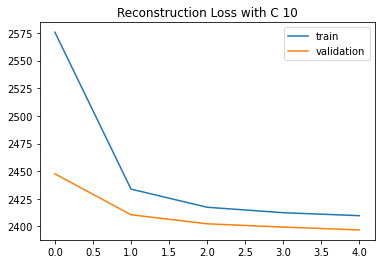

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [35:04<00:00, 701.03s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [35:04<00:00, 701.56s/it, loss=2.52e+03, v_num=1]


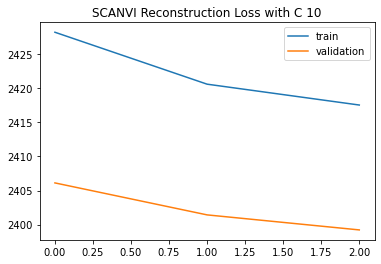

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [05:49<00:00, 70.37s/it, loss=2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:49<00:00, 69.93s/it, loss=2.41e+03, v_num=1]


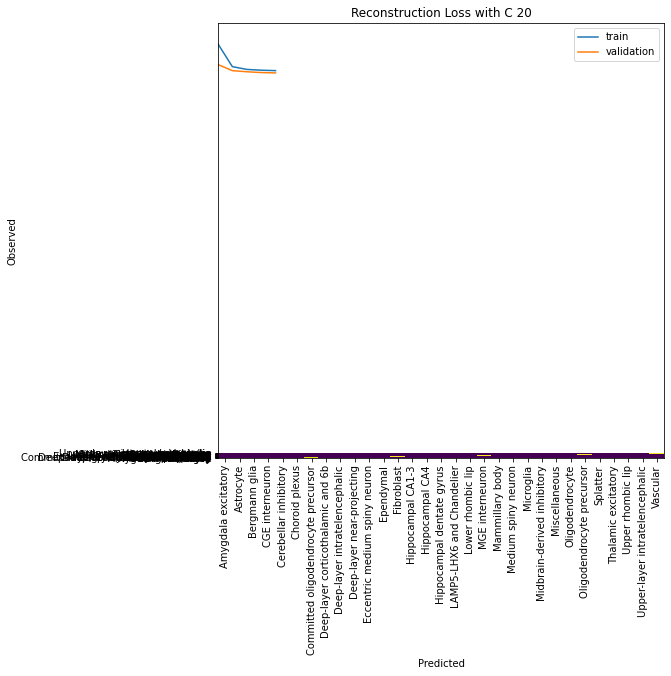

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [37:00<00:00, 747.20s/it, loss=2.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [37:00<00:00, 740.21s/it, loss=2.53e+03, v_num=1]


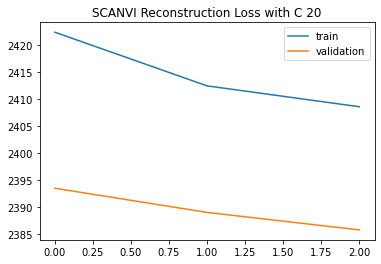

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [06:21<00:00, 77.55s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:21<00:00, 76.30s/it, loss=2.4e+03, v_num=1]


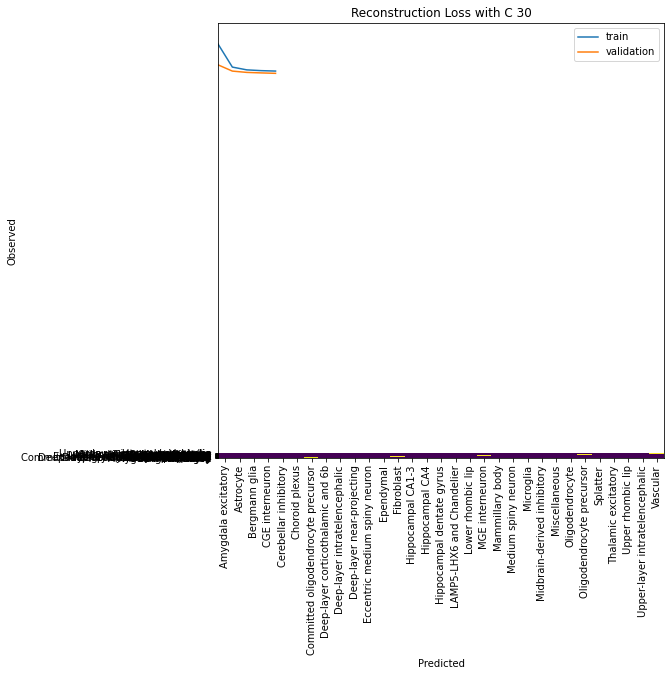

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [40:01<00:00, 799.49s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [40:01<00:00, 800.60s/it, loss=2.54e+03, v_num=1]


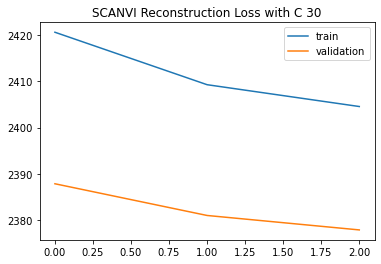

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [06:22<00:00, 78.71s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:22<00:00, 76.57s/it, loss=2.4e+03, v_num=1]


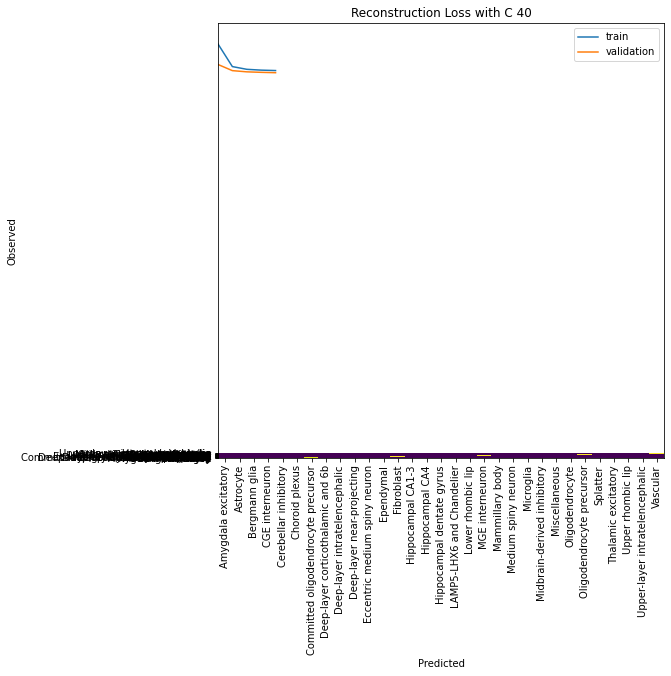

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [41:19<00:00, 826.16s/it, loss=2.53e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [41:19<00:00, 826.65s/it, loss=2.53e+03, v_num=1]


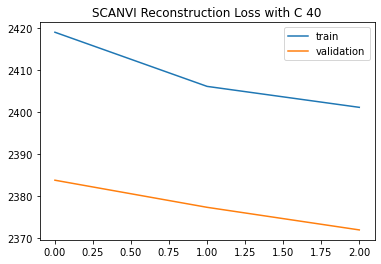

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [06:31<00:00, 79.59s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:31<00:00, 78.35s/it, loss=2.4e+03, v_num=1]


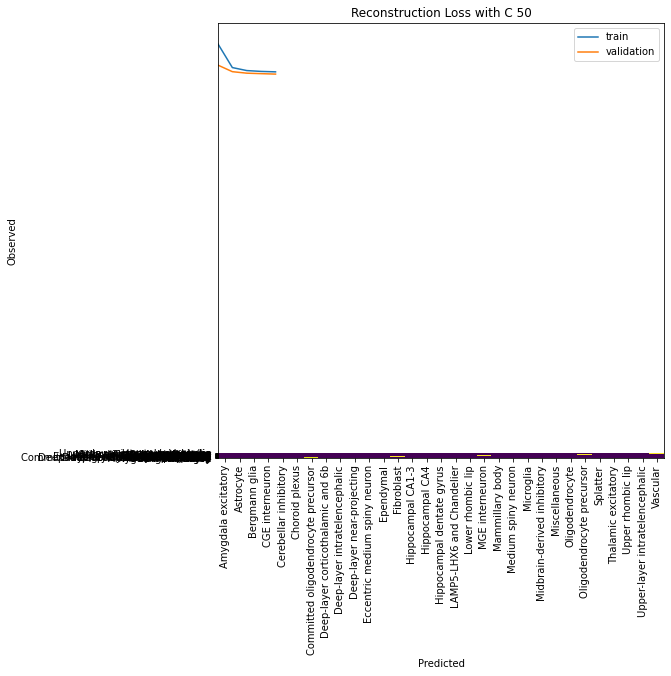

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [40:27<00:00, 812.11s/it, loss=2.51e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [40:27<00:00, 809.33s/it, loss=2.51e+03, v_num=1]


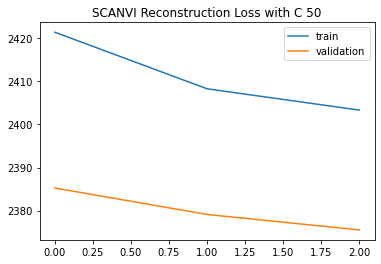

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [07:00<00:00, 84.21s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:00<00:00, 84.00s/it, loss=2.4e+03, v_num=1]


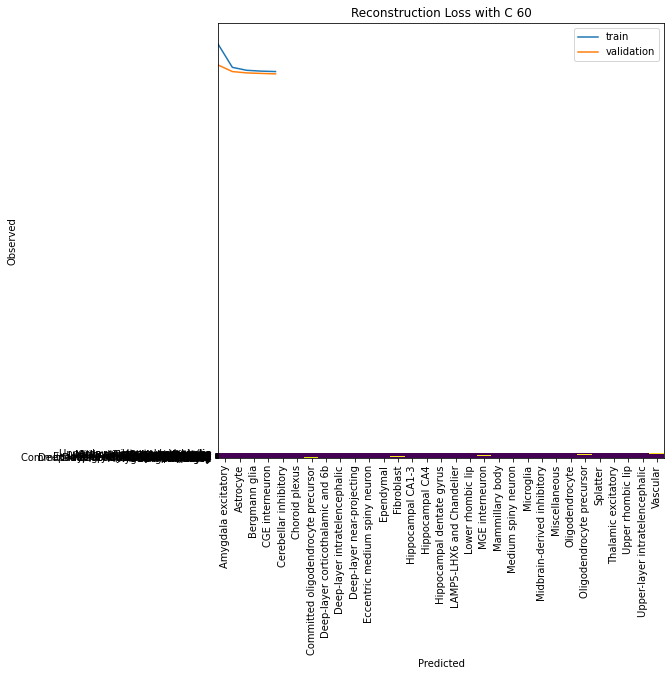

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [40:33<00:00, 810.39s/it, loss=2.5e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [40:34<00:00, 811.36s/it, loss=2.5e+03, v_num=1]


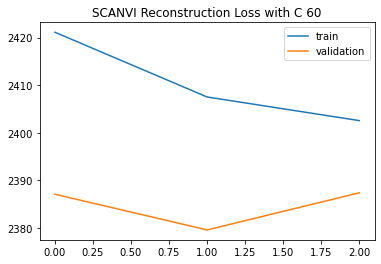

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [06:58<00:00, 83.35s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:58<00:00, 83.64s/it, loss=2.4e+03, v_num=1]


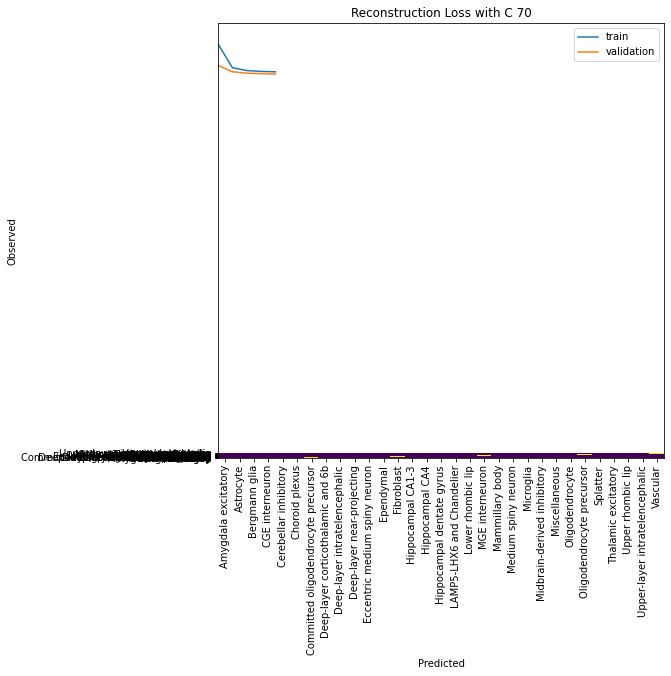

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [39:38<00:00, 781.46s/it, loss=2.55e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [39:38<00:00, 792.71s/it, loss=2.55e+03, v_num=1]


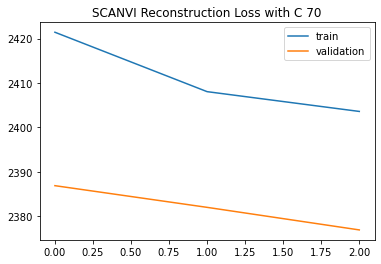

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [05:49<00:00, 69.81s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:49<00:00, 69.95s/it, loss=2.4e+03, v_num=1]


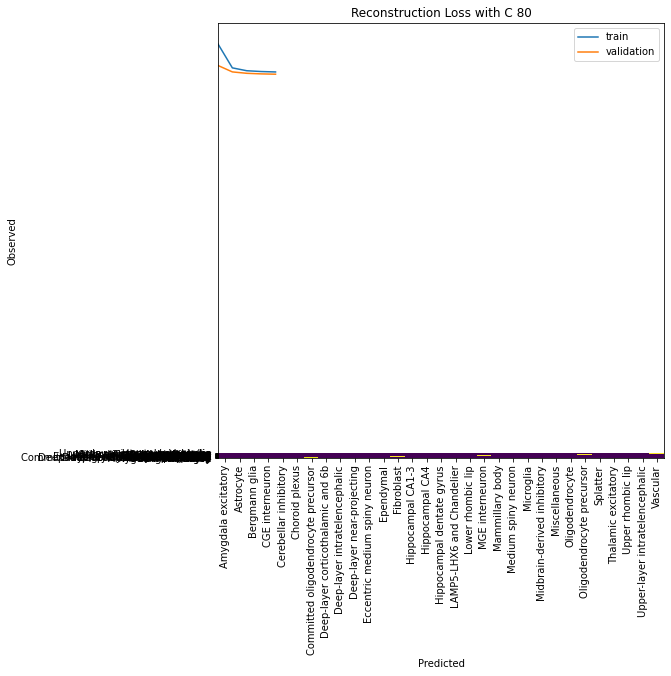

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [35:22<00:00, 707.98s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [35:22<00:00, 707.43s/it, loss=2.52e+03, v_num=1]


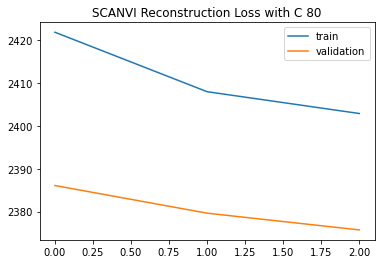

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [05:57<00:00, 71.52s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:57<00:00, 71.44s/it, loss=2.4e+03, v_num=1]


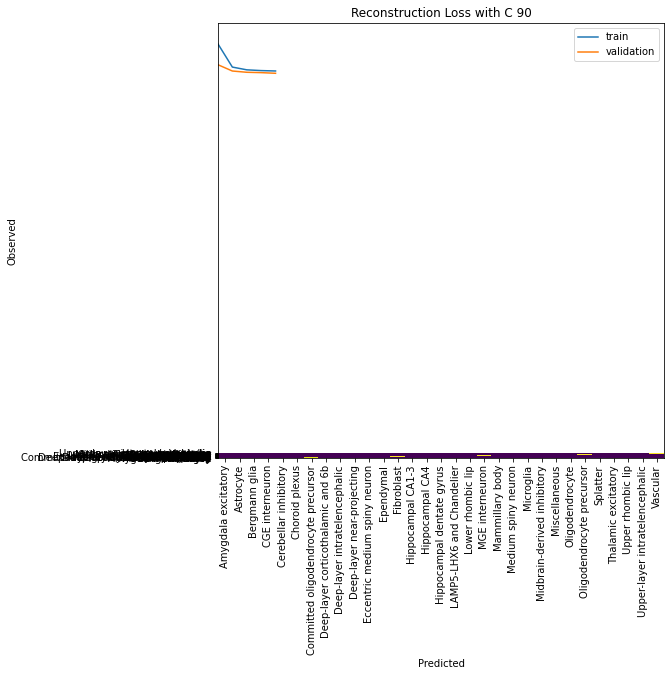

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [35:03<00:00, 700.92s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [35:03<00:00, 701.24s/it, loss=2.52e+03, v_num=1]


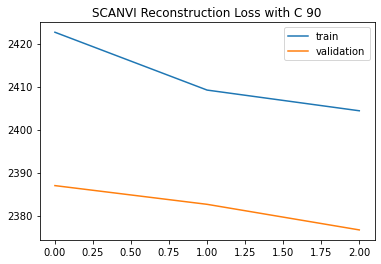

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

Epoch 5/5: 100%|██████████| 5/5 [06:01<00:00, 72.12s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:01<00:00, 72.25s/it, loss=2.4e+03, v_num=1]


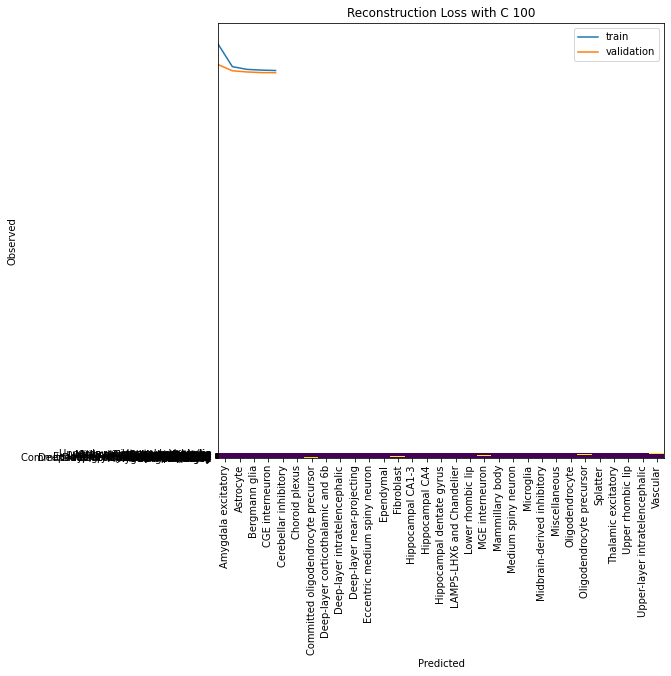

/tmp/ipykernel_83869/4080068037.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [35:12<00:00, 704.27s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [35:12<00:00, 704.11s/it, loss=2.54e+03, v_num=1]


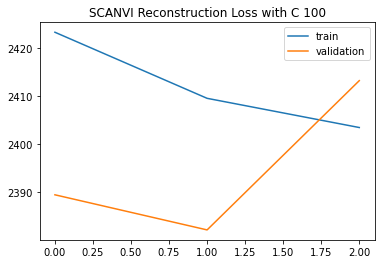

/tmp/ipykernel_83869/4080068037.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/4080068037.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/4080068037.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

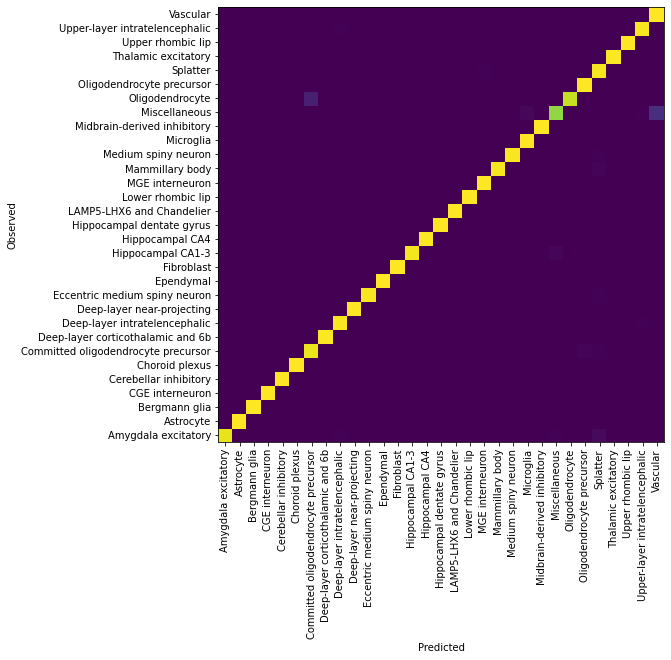

In [ ]:
results=[]
for i in range(1,11):
    i=i*10
    scvi.model.SCVI.setup_anndata(adata, layer="counts")
    vae = scvi.model.SCVI(adata, n_layers=2,n_latent=i)
    vae.train(max_epochs=5,use_gpu=4,train_size=0.8, batch_size=1024,early_stopping=True)
    vae.save(f'model/latent_c_{i}')
    plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'Reconstruction Loss with C {i}')
    plt.legend()
    plt.show()

    np.random.seed(0)
    unlabel_idx=np.sort(np.random.choice(range(adata.shape[0]),int(adata.shape[0]*0.2),replace=False))
    adata.obs["celltype_scanvi"]=list(adata.obs.Supercluster)
    adata.obs.celltype_scanvi[unlabel_idx]='Unknown'
    lvae_all = scvi.model.SCANVI.from_scvi_model(
        vae,
        adata=adata,
        unlabeled_category="Unknown",
        labels_key="celltype_scanvi",
    )
    lvae_all.train(max_epochs=3,use_gpu=4,n_samples_per_label=1000,early_stopping=True,enable_checkpointing=True,check_val_every_n_epoch=1)
    lvae_all.save(f'model/scanvi_latent_c_{i}')
    plt.plot(lvae_all.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(lvae_all.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'SCANVI Reconstruction Loss with C {i}')
    plt.legend()
    plt.show()

    tmp1=adata.obs[['cell','Supercluster']]
    tmp1['predict']=lvae_all.predict()
    tmp1['unlabel']=False
    tmp1['unlabel'][unlabel_idx]=True
    results.append([float(vae.get_elbo().cpu().numpy()),
                    float(lvae_all.get_elbo().cpu().numpy()),
                    sum((tmp1.Supercluster==tmp1.predict)[tmp1.unlabel])/sum(tmp1.unlabel),
                    sum((tmp1.Supercluster==tmp1.predict)[~tmp1.unlabel])/sum(~tmp1.unlabel)])
    
    df = tmp1[tmp1.unlabel].groupby(["Supercluster", "predict"]).size().unstack(fill_value=0)
    conf_mat = df / df.sum(axis=1).values[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    _ = plt.pcolor(conf_mat)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Predicted")
    plt.ylabel("Observed")

In [ ]:
results

[[-2451.444091796875,
  -2452.38623046875,
  0.9765301412940403,
  0.9768956167896427],
 [-2480.2734375, -2479.841552734375, 0.9045326582007975, 0.9047086566030119],
 [-2512.29248046875,
  -2509.78076171875,
  0.9136846416746928,
  0.9135278343355435],
 [-2533.89697265625,
  -2535.51708984375,
  0.9749823029993634,
  0.9752264619110654],
 [-2561.75341796875, -2562.859375, 0.9827274305735906, 0.9829574797727664],
 [-2581.996337890625,
  -2589.3955078125,
  0.9724312636623071,
  0.9726602151239753],
 [-2602.36962890625, -2582.68359375, 0.9702037418211661, 0.9704490208416191],
 [-2619.706298828125,
  -2599.223388671875,
  0.9837172753890743,
  0.9838827681184369],
 [-2631.88916015625, -2586.5615234375, 0.9518418978901614, 0.9521324668617662],
 [-2646.8447265625,
  -2652.302490234375,
  0.9796169137321304,
  0.9799560432384944]]

In [ ]:
pd.DataFrame(results,columns=['scvi','scanvi','validation','training']).to_csv('results/latent_cs.csv')

In [ ]:
pd.DataFrame(results,columns=['scvi','scanvi','validation','training'])

scvi       scanvi  validation  training
0 -2451.444092 -2452.386230    0.976530  0.976896
1 -2480.273438 -2479.841553    0.904533  0.904709
2 -2512.292480 -2509.780762    0.913685  0.913528
3 -2533.896973 -2535.517090    0.974982  0.975226
4 -2561.753418 -2562.859375    0.982727  0.982957
5 -2581.996338 -2589.395508    0.972431  0.972660
6 -2602.369629 -2582.683594    0.970204  0.970449
7 -2619.706299 -2599.223389    0.983717  0.983883
8 -2631.889160 -2586.561523    0.951842  0.952132
9 -2646.844727 -2652.302490    0.979617  0.979956

# 2. Network layers (C=10)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:14<00:00, 74.96s/it, loss=2.44e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:14<00:00, 74.82s/it, loss=2.44e+03, v_num=1]


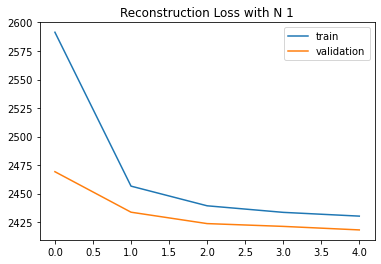

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [33:44<00:00, 677.35s/it, loss=2.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [33:44<00:00, 674.88s/it, loss=2.58e+03, v_num=1]


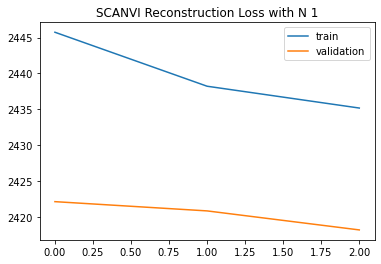

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

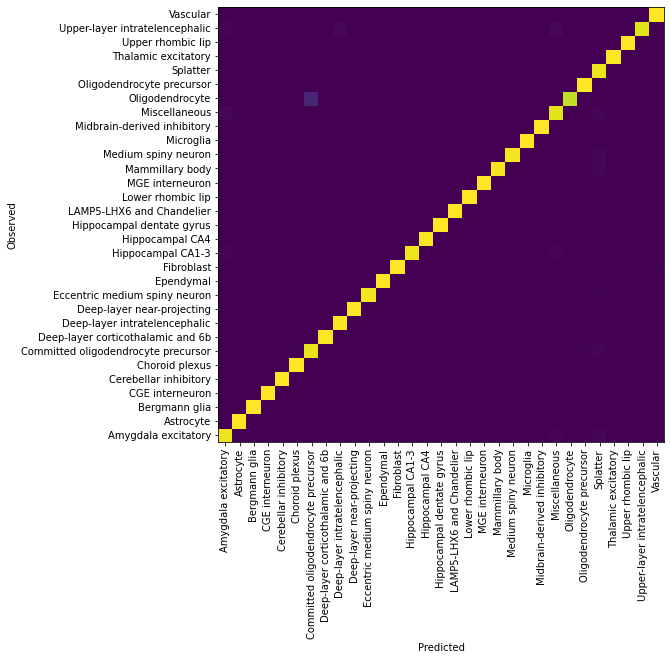

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:27<00:00, 79.59s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:27<00:00, 77.51s/it, loss=2.4e+03, v_num=1]


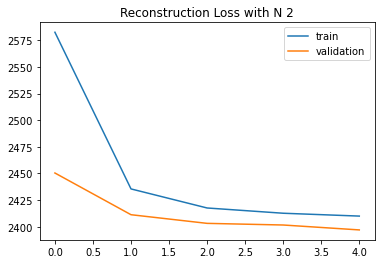

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [40:12<00:00, 810.25s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [40:12<00:00, 804.18s/it, loss=2.52e+03, v_num=1]


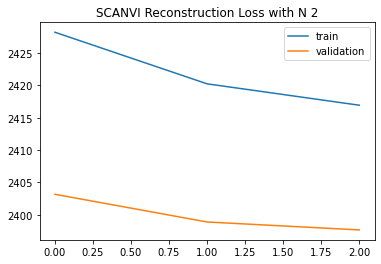

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

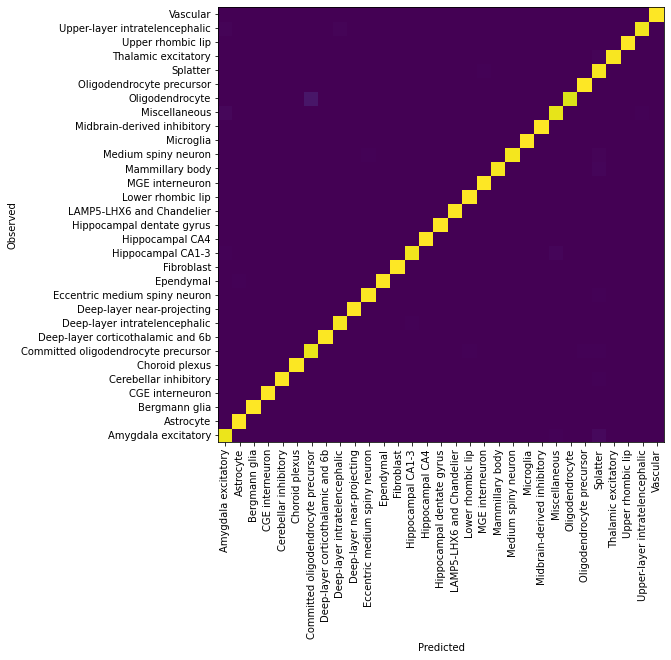

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:09<00:00, 73.82s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:09<00:00, 73.83s/it, loss=2.4e+03, v_num=1]


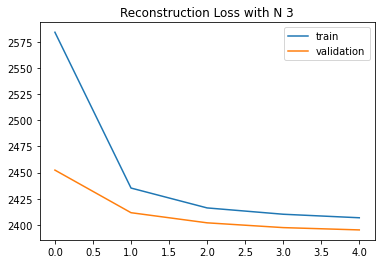

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [40:03<00:00, 800.75s/it, loss=2.55e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [40:03<00:00, 801.21s/it, loss=2.55e+03, v_num=1]


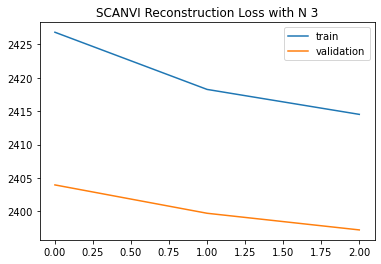

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

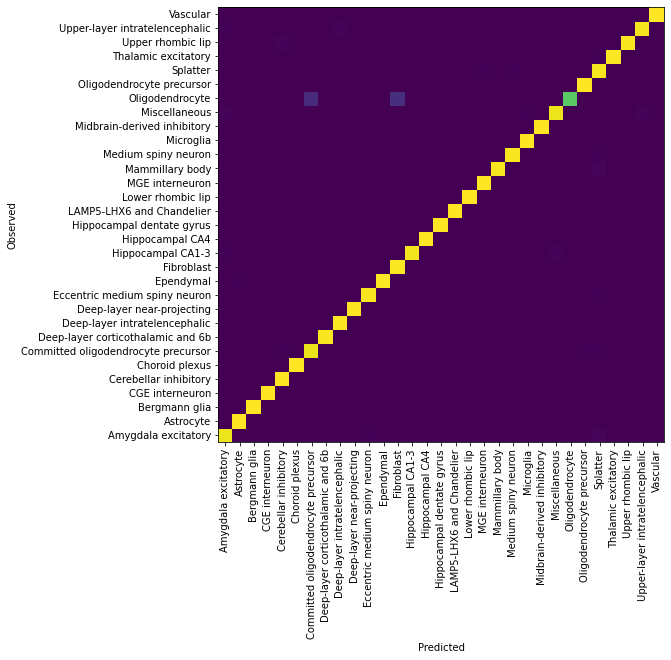

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:32<00:00, 78.71s/it, loss=2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:32<00:00, 78.56s/it, loss=2.41e+03, v_num=1]


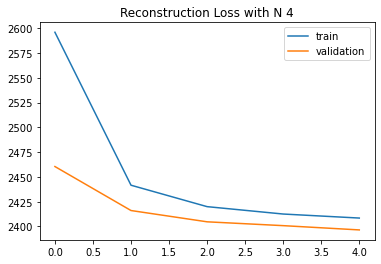

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [43:34<00:00, 872.30s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [43:34<00:00, 871.52s/it, loss=2.54e+03, v_num=1]


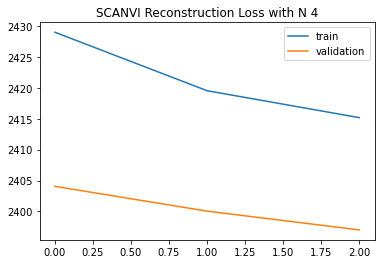

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

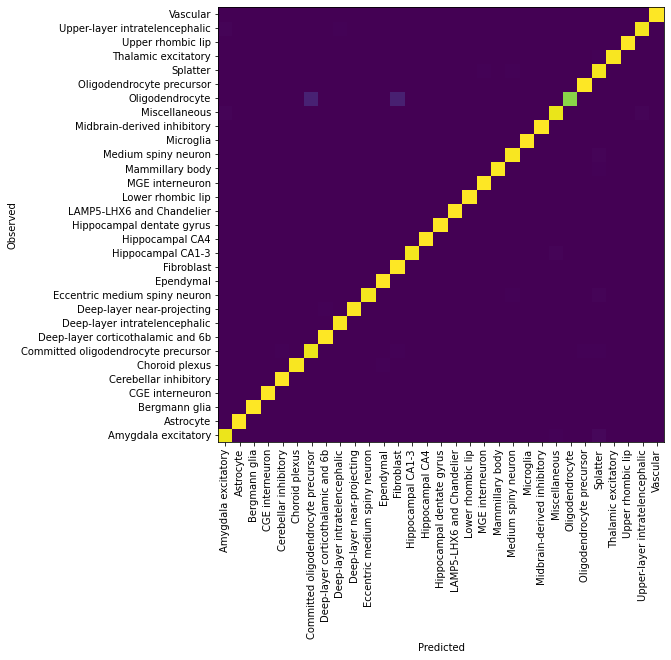

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:55<00:00, 83.26s/it, loss=2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:55<00:00, 83.05s/it, loss=2.41e+03, v_num=1]


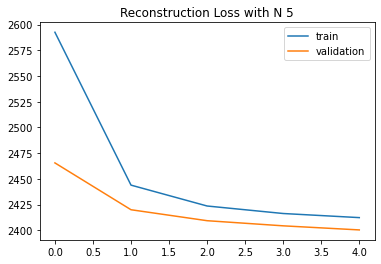

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [47:57<00:00, 958.70s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [47:57<00:00, 959.25s/it, loss=2.54e+03, v_num=1]


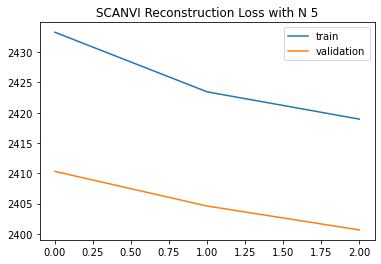

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

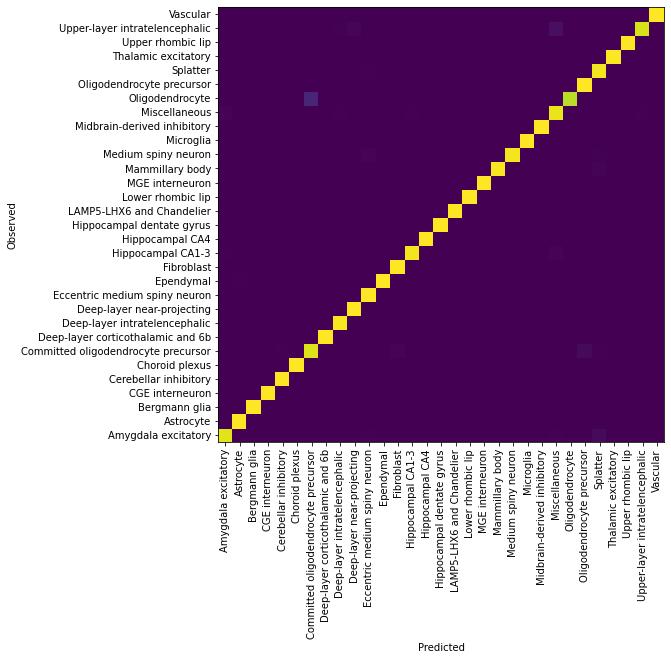

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:14<00:00, 87.05s/it, loss=2.42e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:14<00:00, 86.86s/it, loss=2.42e+03, v_num=1]


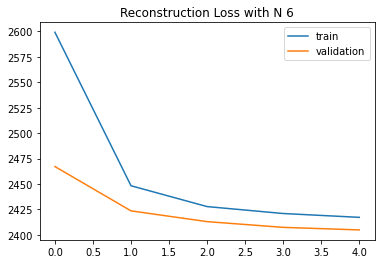

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [53:46<00:00, 1077.41s/it, loss=2.58e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [53:46<00:00, 1075.65s/it, loss=2.58e+03, v_num=1]


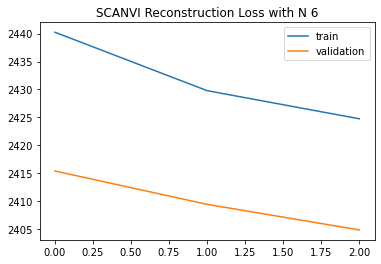

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

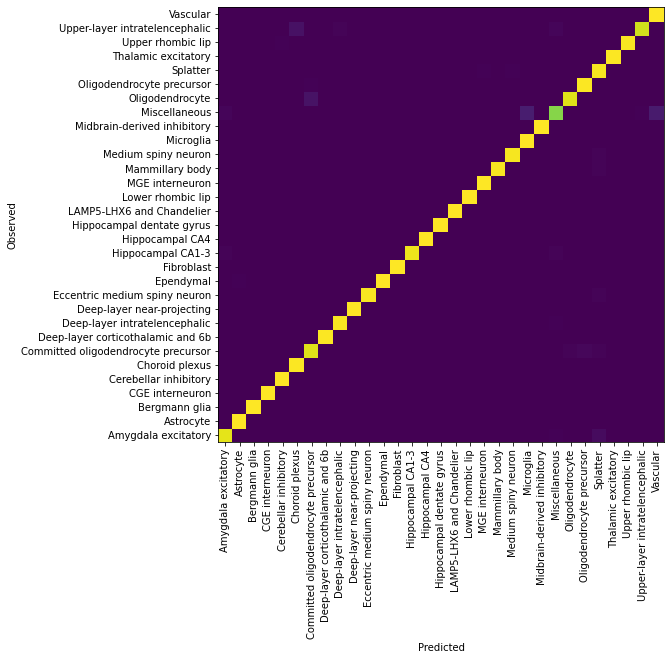

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:53<00:00, 94.86s/it, loss=2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:53<00:00, 94.60s/it, loss=2.41e+03, v_num=1]


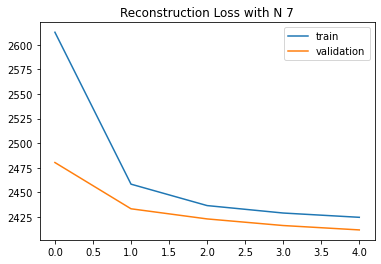

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [58:07<00:00, 1161.40s/it, loss=2.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [58:07<00:00, 1162.59s/it, loss=2.56e+03, v_num=1]


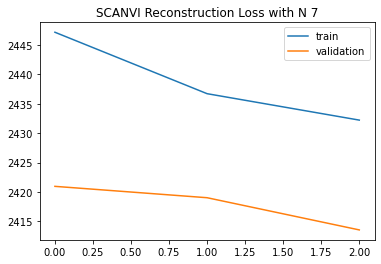

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

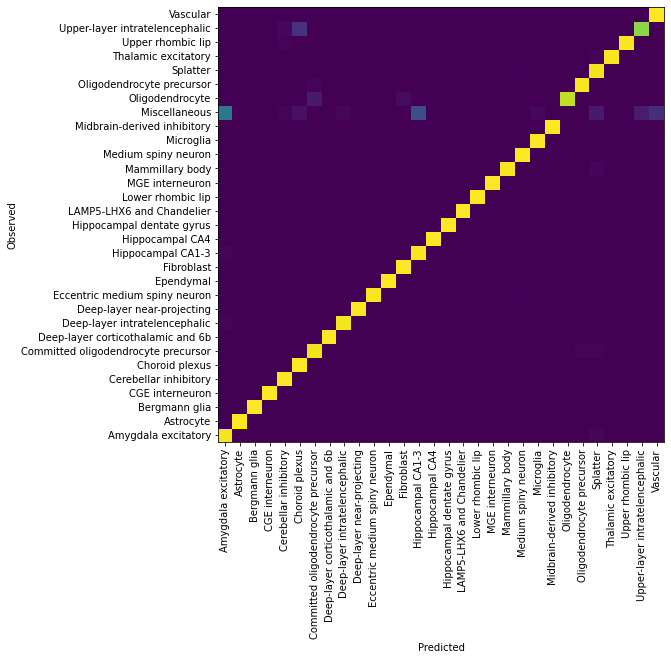

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:57<00:00, 95.77s/it, loss=2.43e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:57<00:00, 95.48s/it, loss=2.43e+03, v_num=1]


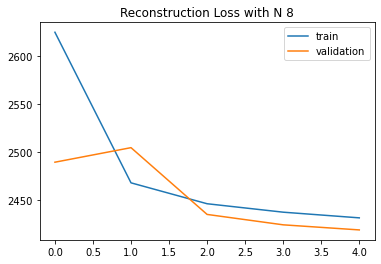

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [1:02:56<00:00, 1259.97s/it, loss=2.57e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [1:02:57<00:00, 1259.14s/it, loss=2.57e+03, v_num=1]


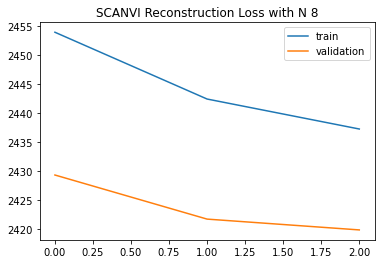

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

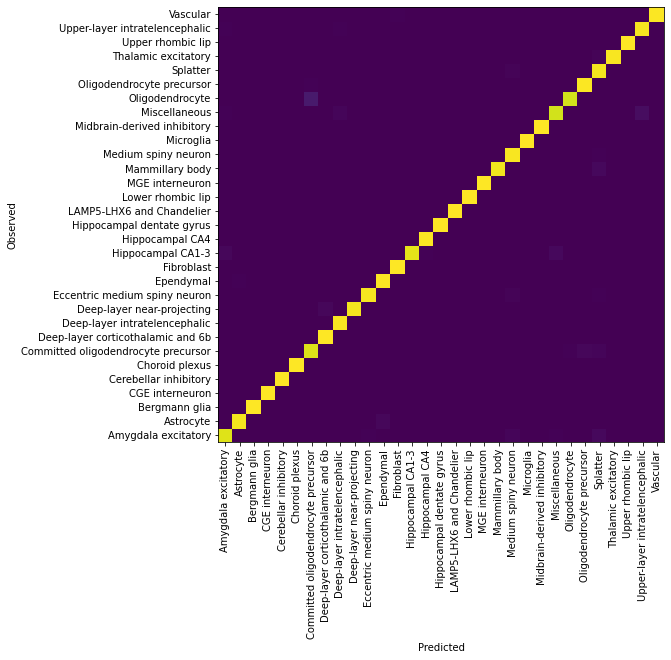

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [08:27<00:00, 101.44s/it, loss=2.45e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [08:27<00:00, 101.56s/it, loss=2.45e+03, v_num=1]


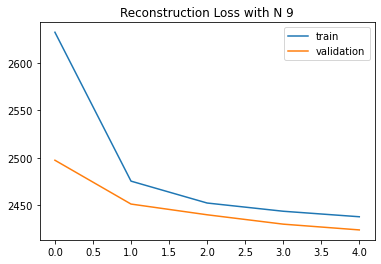

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [1:07:04<00:00, 1342.27s/it, loss=2.59e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [1:07:04<00:00, 1341.51s/it, loss=2.59e+03, v_num=1]


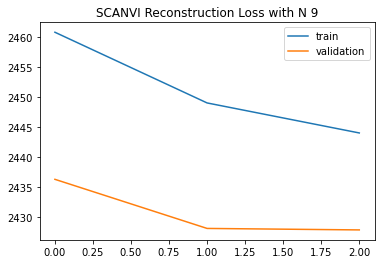

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

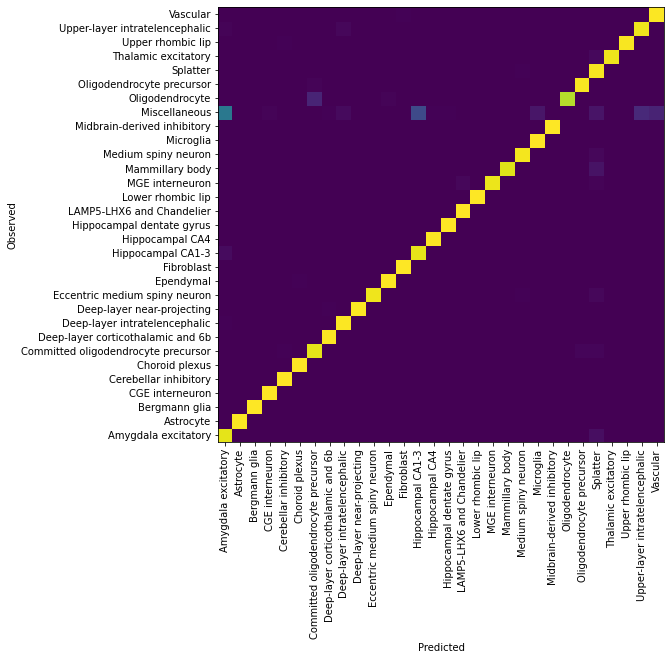

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [08:52<00:00, 106.19s/it, loss=2.44e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [08:52<00:00, 106.47s/it, loss=2.44e+03, v_num=1]


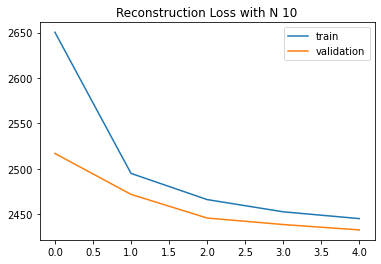

/tmp/ipykernel_83869/1971638546.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [1:12:02<00:00, 1442.08s/it, loss=2.59e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [1:12:03<00:00, 1441.30s/it, loss=2.59e+03, v_num=1]


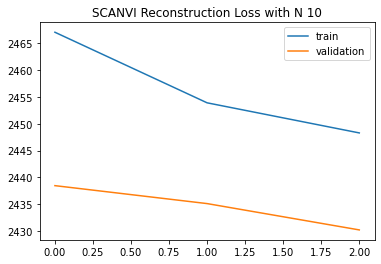

/tmp/ipykernel_83869/1971638546.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/1971638546.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/1971638546.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel

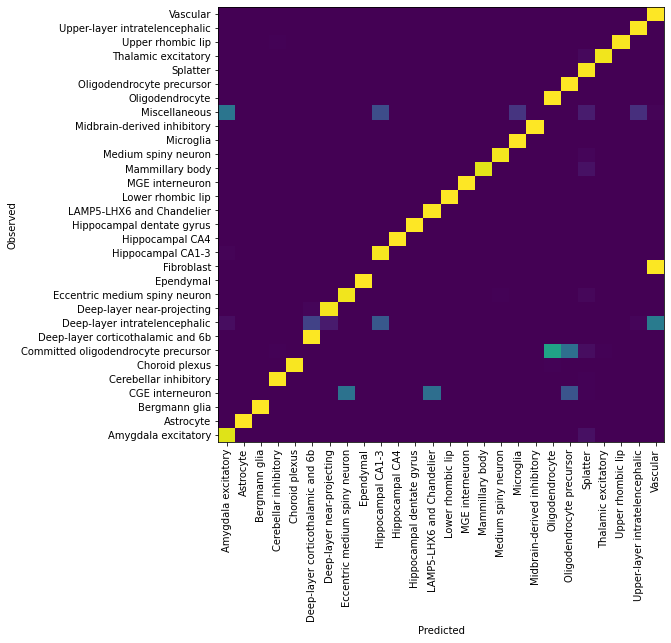

In [ ]:
results1=[]
for i in range(1,11):

    scvi.model.SCVI.setup_anndata(adata, layer="counts")
    vae = scvi.model.SCVI(adata, n_layers=i,n_latent=10)
    vae.train(max_epochs=5,use_gpu=4,train_size=0.8, batch_size=1024,early_stopping=True)
    vae.save(f'model/layer_n_{i}')
    plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    np.random.seed(0)
    unlabel_idx=np.sort(np.random.choice(range(adata.shape[0]),int(adata.shape[0]*0.2),replace=False))
    adata.obs["celltype_scanvi"]=list(adata.obs.Supercluster)
    adata.obs.celltype_scanvi[unlabel_idx]='Unknown'
    lvae_all = scvi.model.SCANVI.from_scvi_model(
        vae,
        adata=adata,
        unlabeled_category="Unknown",
        labels_key="celltype_scanvi",
    )
    lvae_all.train(max_epochs=3,use_gpu=4,n_samples_per_label=1000,early_stopping=True,enable_checkpointing=True,check_val_every_n_epoch=1)
    lvae_all.save(f'model/scanvi_layer_n_{i}')
    plt.plot(lvae_all.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(lvae_all.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'SCANVI Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    tmp1=adata.obs[['cell','Supercluster']]
    tmp1['predict']=lvae_all.predict()
    tmp1['unlabel']=False
    tmp1['unlabel'][unlabel_idx]=True
    results1.append([float(vae.get_elbo().cpu().numpy()),
                    float(lvae_all.get_elbo().cpu().numpy()),
                    sum((tmp1.Supercluster==tmp1.predict)[tmp1.unlabel])/sum(tmp1.unlabel),
                    sum((tmp1.Supercluster==tmp1.predict)[~tmp1.unlabel])/sum(~tmp1.unlabel)])
    
    df = tmp1[tmp1.unlabel].groupby(["Supercluster", "predict"]).size().unstack(fill_value=0)
    conf_mat = df / df.sum(axis=1).values[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    _ = plt.pcolor(conf_mat)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.show()

In [ ]:
results1

[[-2474.87109375, -2468.826904296875, 0.97210329409076, 0.9725908370483376],
 [-2450.97021484375,
  -2451.752197265625,
  0.9827111062962738,
  0.9830246318138917],
 [-2448.15966796875, -2451.220703125, 0.9541213606136741, 0.9543084155976754],
 [-2448.189453125, -2448.688720703125, 0.9656136518447176, 0.965900861326954],
 [-2452.82861328125,
  -2449.734619140625,
  0.9700998600564227,
  0.970346994259799],
 [-2455.523681640625, -2447.069580078125, 0.975687214974408, 0.97580708591306],
 [-2463.993408203125,
  -2447.746337890625,
  0.9488797835697633,
  0.94864352876927],
 [-2470.67236328125,
  -2454.01806640625,
  0.9805755940181912,
  0.9805329571829682],
 [-2475.44482421875,
  -2452.648681640625,
  0.9639129589533467,
  0.9638098729082696],
 [-2486.048583984375, -2458.21484375, 0.8466185743563411, 0.8465267925513917]]

In [ ]:
pd.DataFrame(results1,columns=['scvi','scanvi','validation','training']).to_csv('results/layer_ns.csv')

In [ ]:
pd.DataFrame(results1,columns=['scvi','scanvi','validation','training'])

scvi       scanvi  validation  training
0 -2474.871094 -2468.826904    0.972103  0.972591
1 -2450.970215 -2451.752197    0.982711  0.983025
2 -2448.159668 -2451.220703    0.954121  0.954308
3 -2448.189453 -2448.688721    0.965614  0.965901
4 -2452.828613 -2449.734619    0.970100  0.970347
5 -2455.523682 -2447.069580    0.975687  0.975807
6 -2463.993408 -2447.746338    0.948880  0.948644
7 -2470.672363 -2454.018066    0.980576  0.980533
8 -2475.444824 -2452.648682    0.963913  0.963810
9 -2486.048584 -2458.214844    0.846619  0.846527

# 3. Network layers (C=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [05:38<00:00, 67.53s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [05:38<00:00, 67.61s/it, loss=2.4e+03, v_num=1]


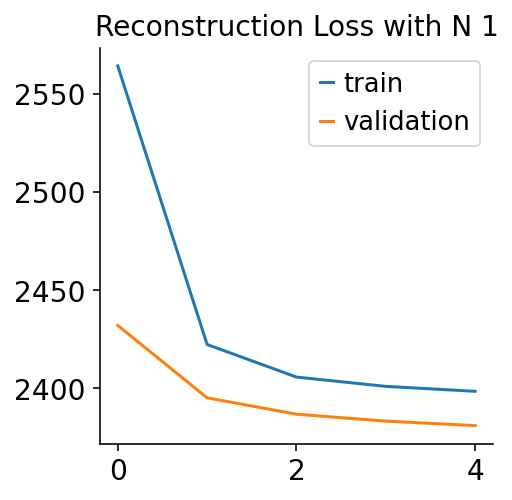

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [31:06<00:00, 622.55s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [31:07<00:00, 622.43s/it, loss=2.54e+03, v_num=1]


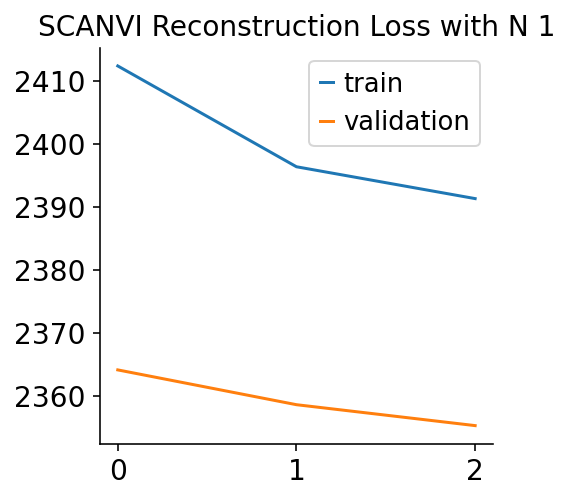

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

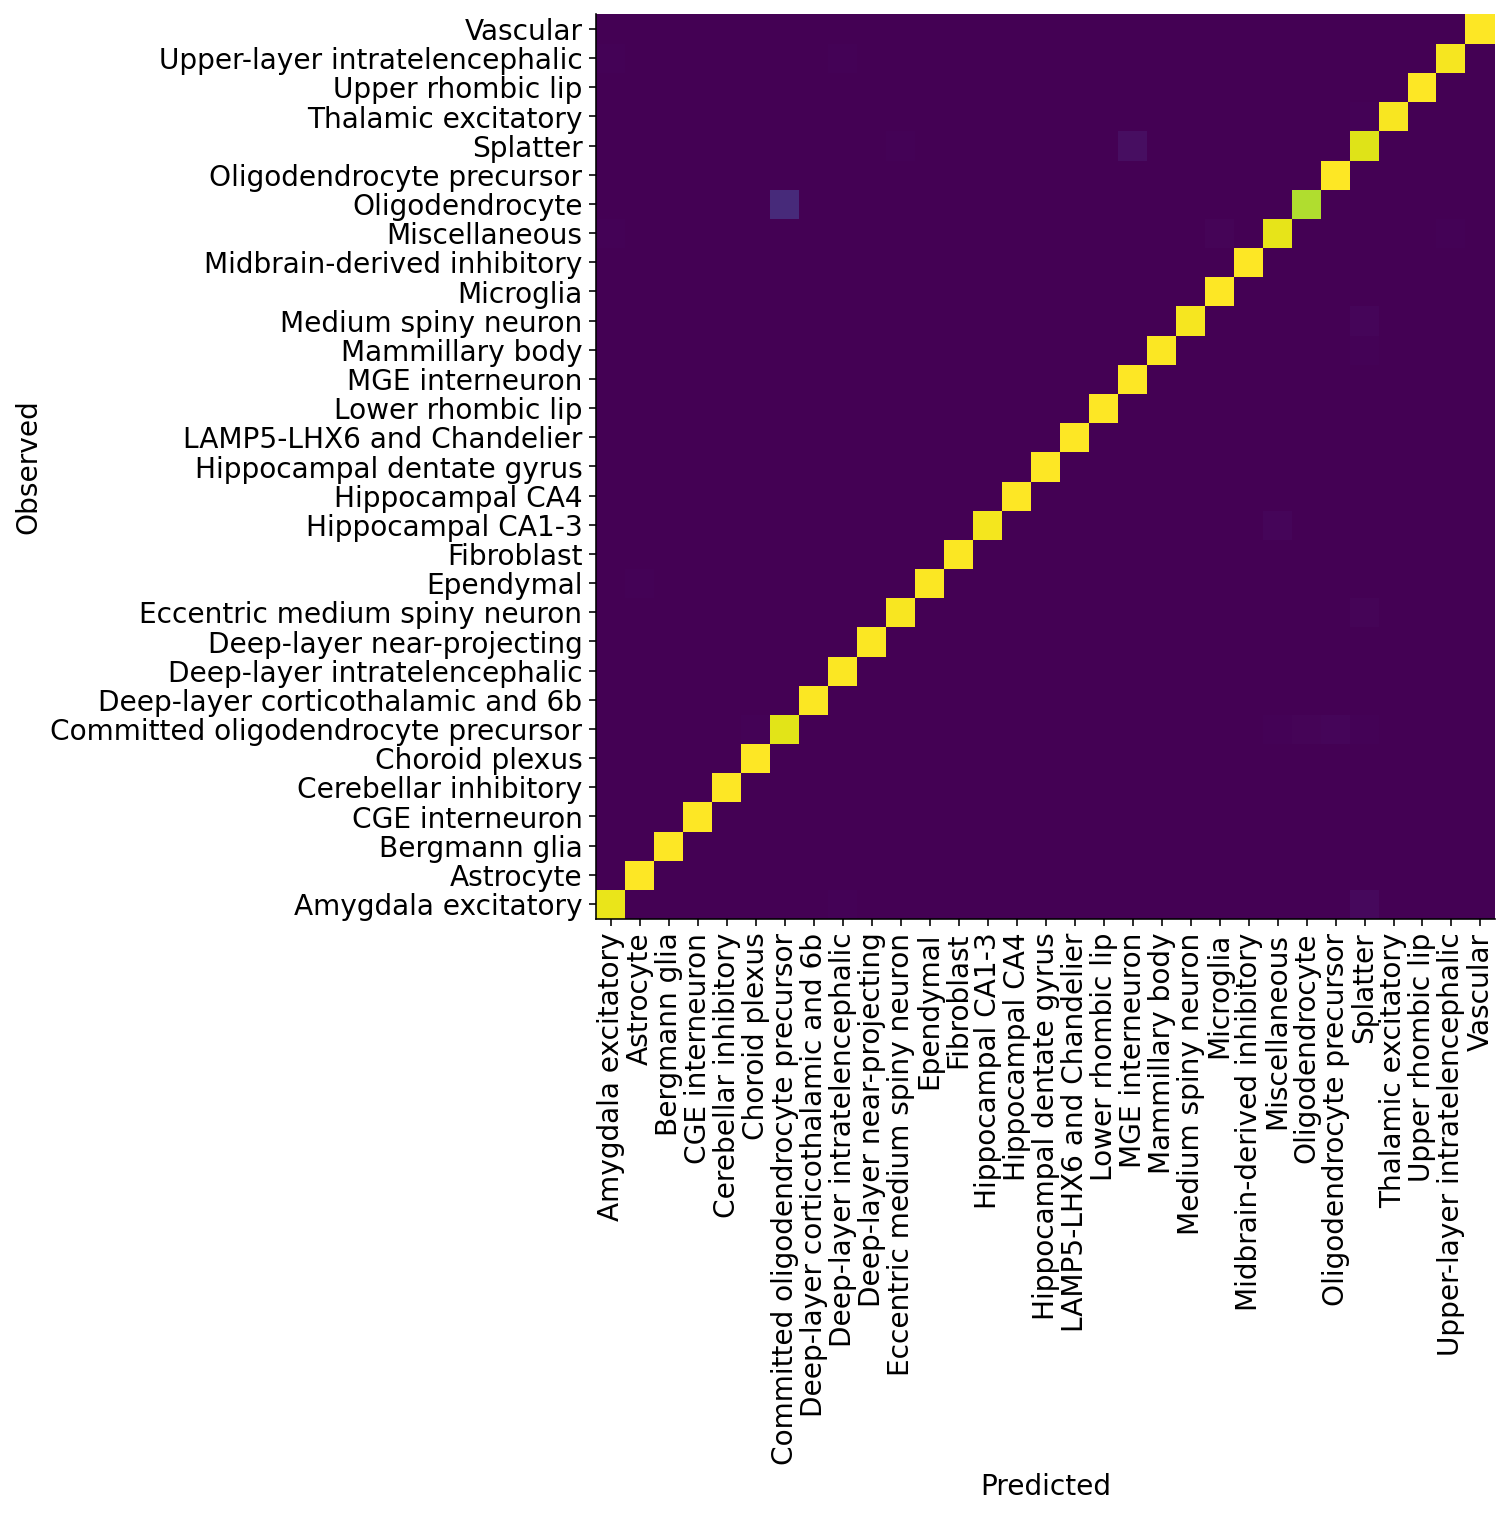

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:00<00:00, 71.91s/it, loss=2.39e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:00<00:00, 72.02s/it, loss=2.39e+03, v_num=1]


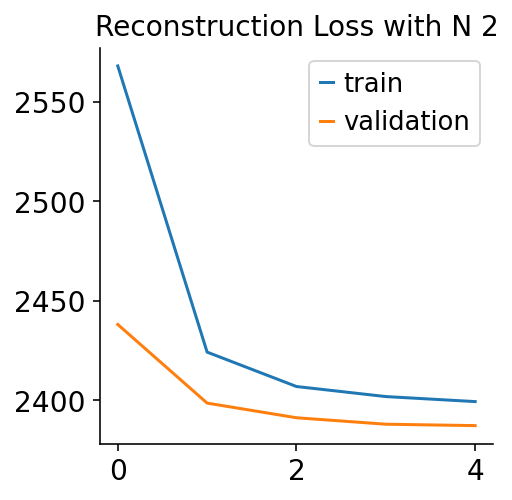

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [35:47<00:00, 719.27s/it, loss=2.47e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [35:48<00:00, 716.08s/it, loss=2.47e+03, v_num=1]


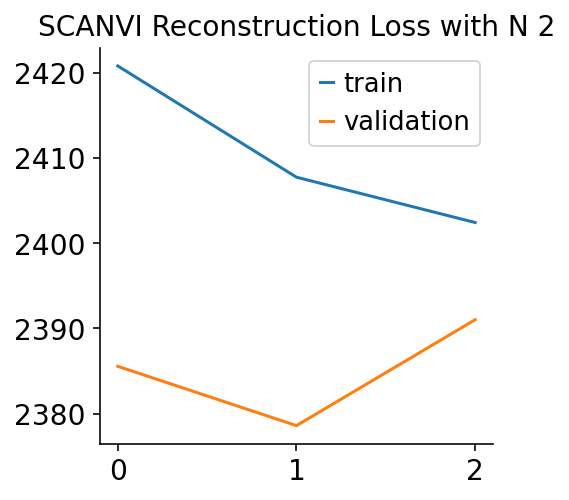

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

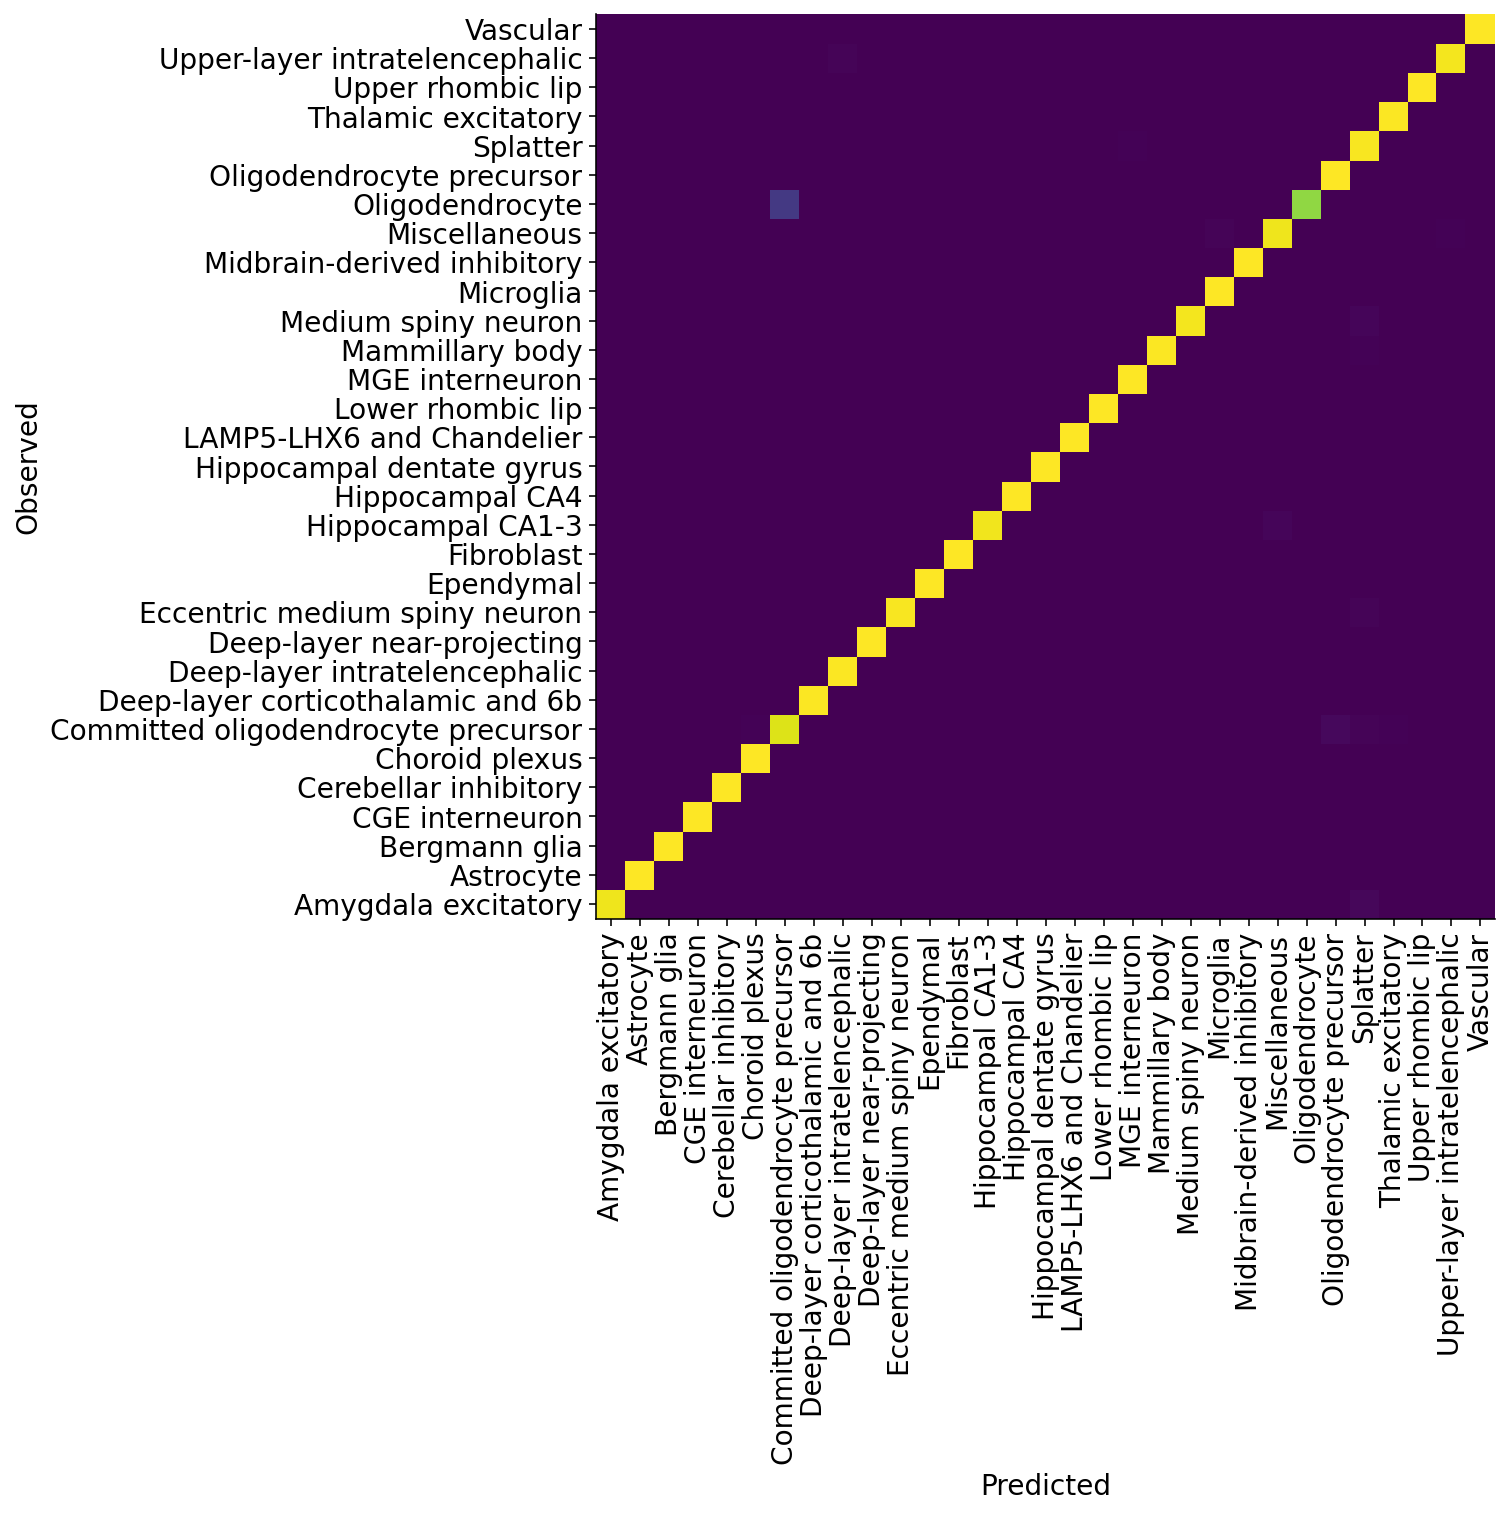

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:22<00:00, 76.51s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:22<00:00, 76.59s/it, loss=2.4e+03, v_num=1]


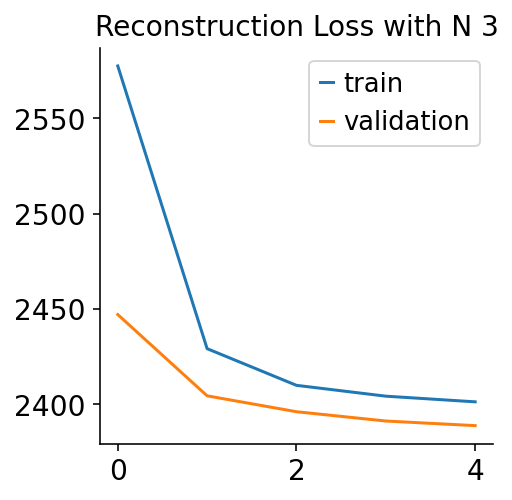

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [39:10<00:00, 781.51s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [39:11<00:00, 783.68s/it, loss=2.54e+03, v_num=1]


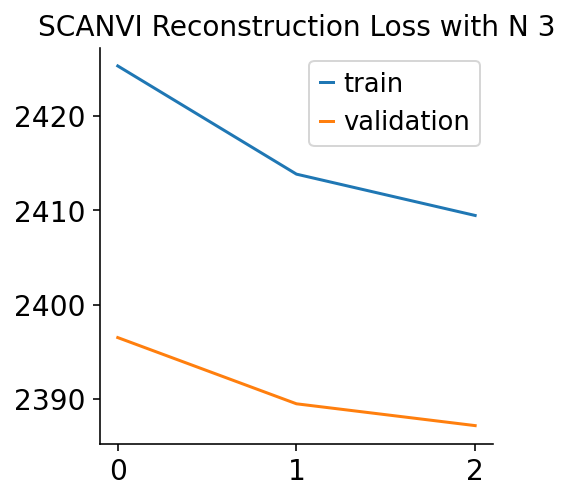

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

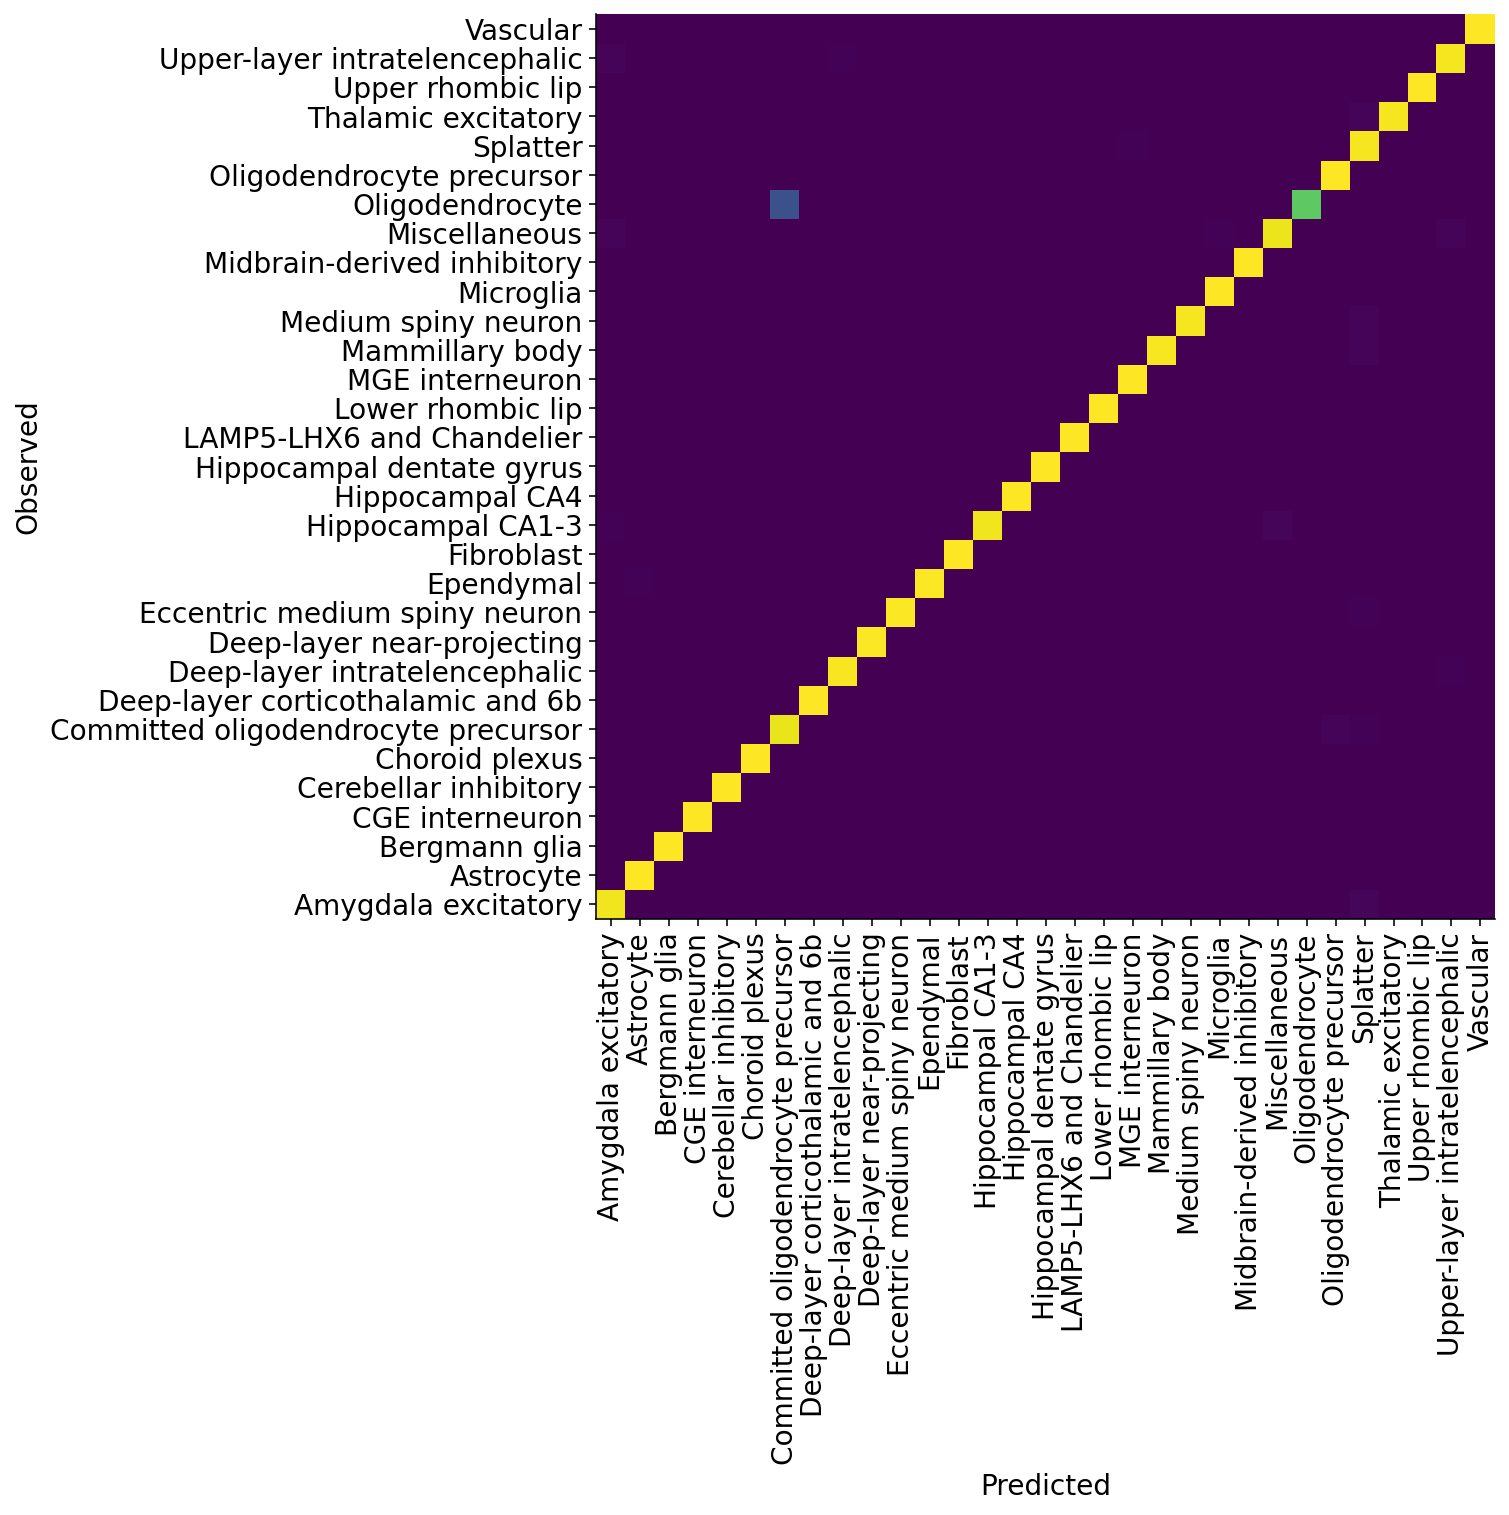

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:49<00:00, 81.78s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:49<00:00, 81.92s/it, loss=2.4e+03, v_num=1]


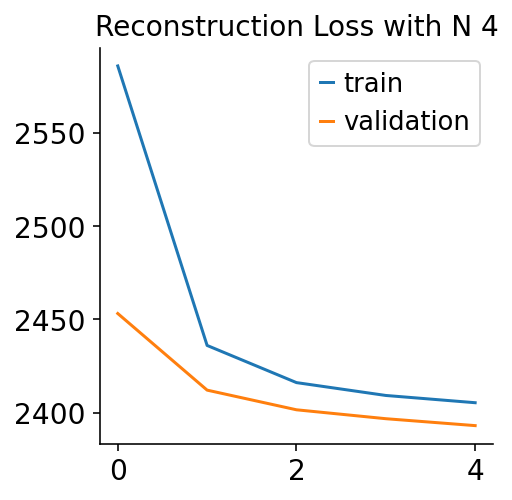

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [43:34<00:00, 873.39s/it, loss=2.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [43:35<00:00, 871.68s/it, loss=2.56e+03, v_num=1]


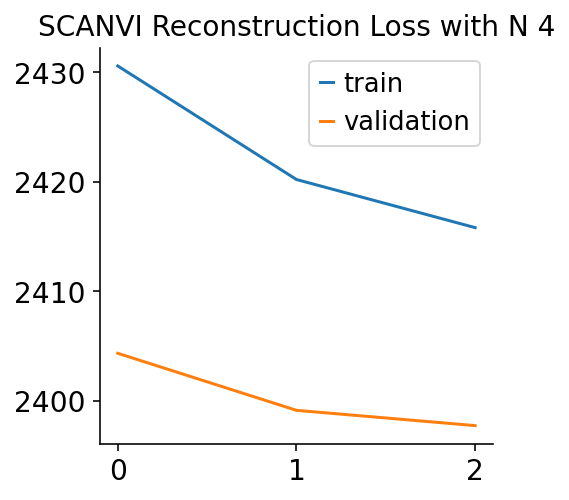

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

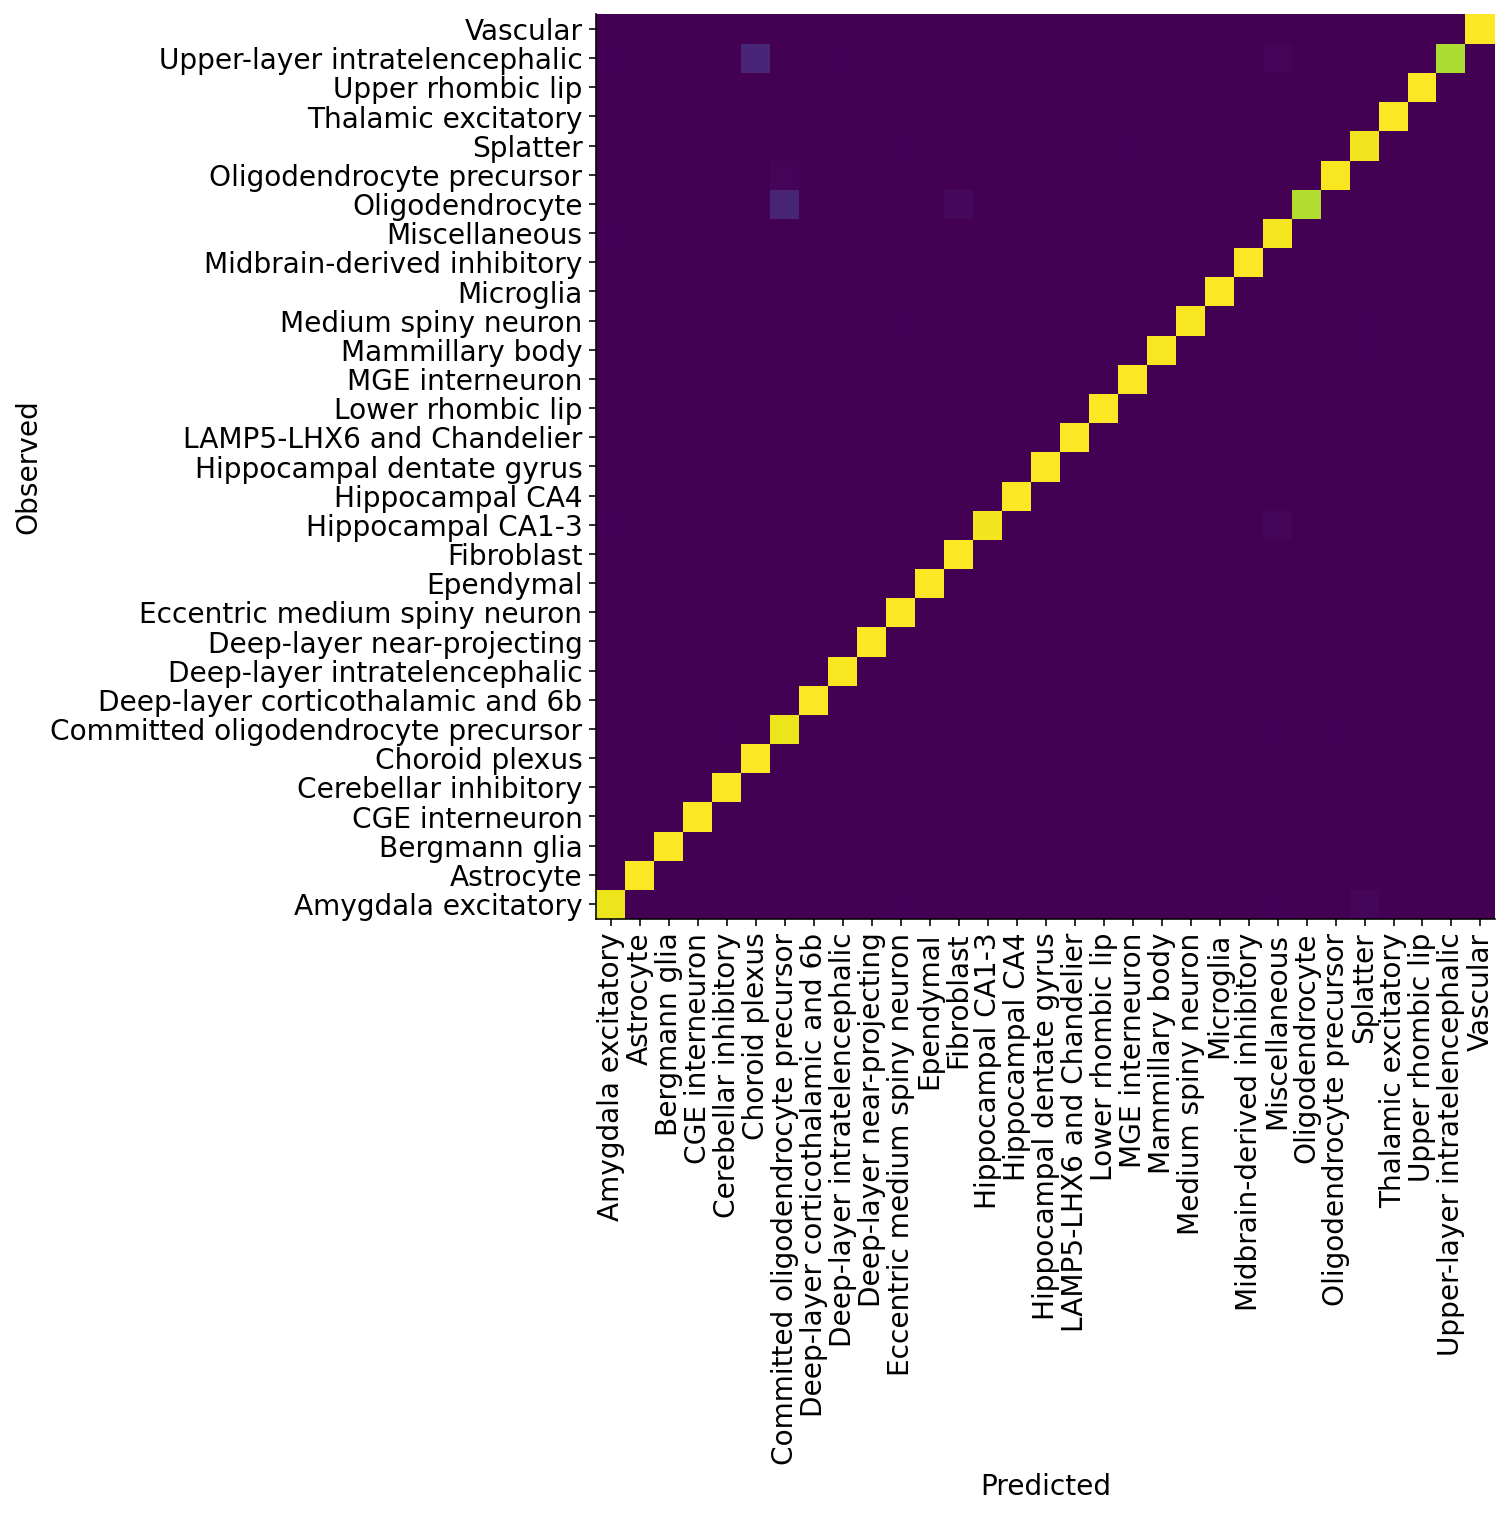

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:09<00:00, 85.96s/it, loss=2.41e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:09<00:00, 85.97s/it, loss=2.41e+03, v_num=1]


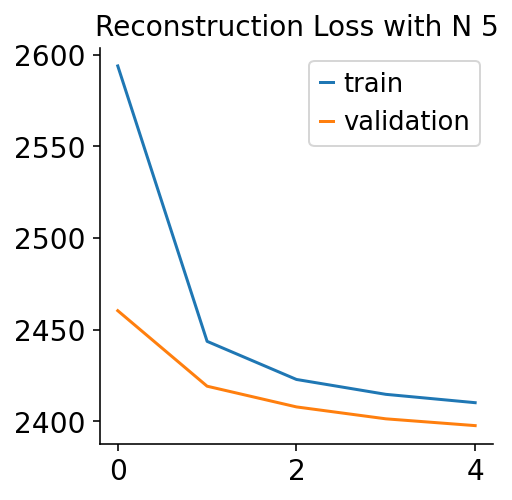

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [48:02<00:00, 961.88s/it, loss=2.5e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [48:03<00:00, 961.04s/it, loss=2.5e+03, v_num=1]


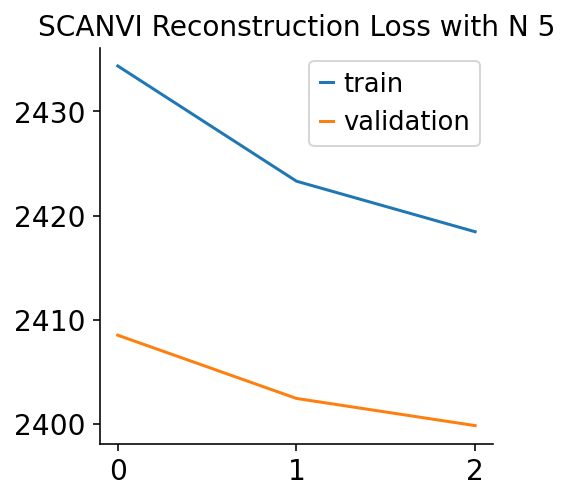

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

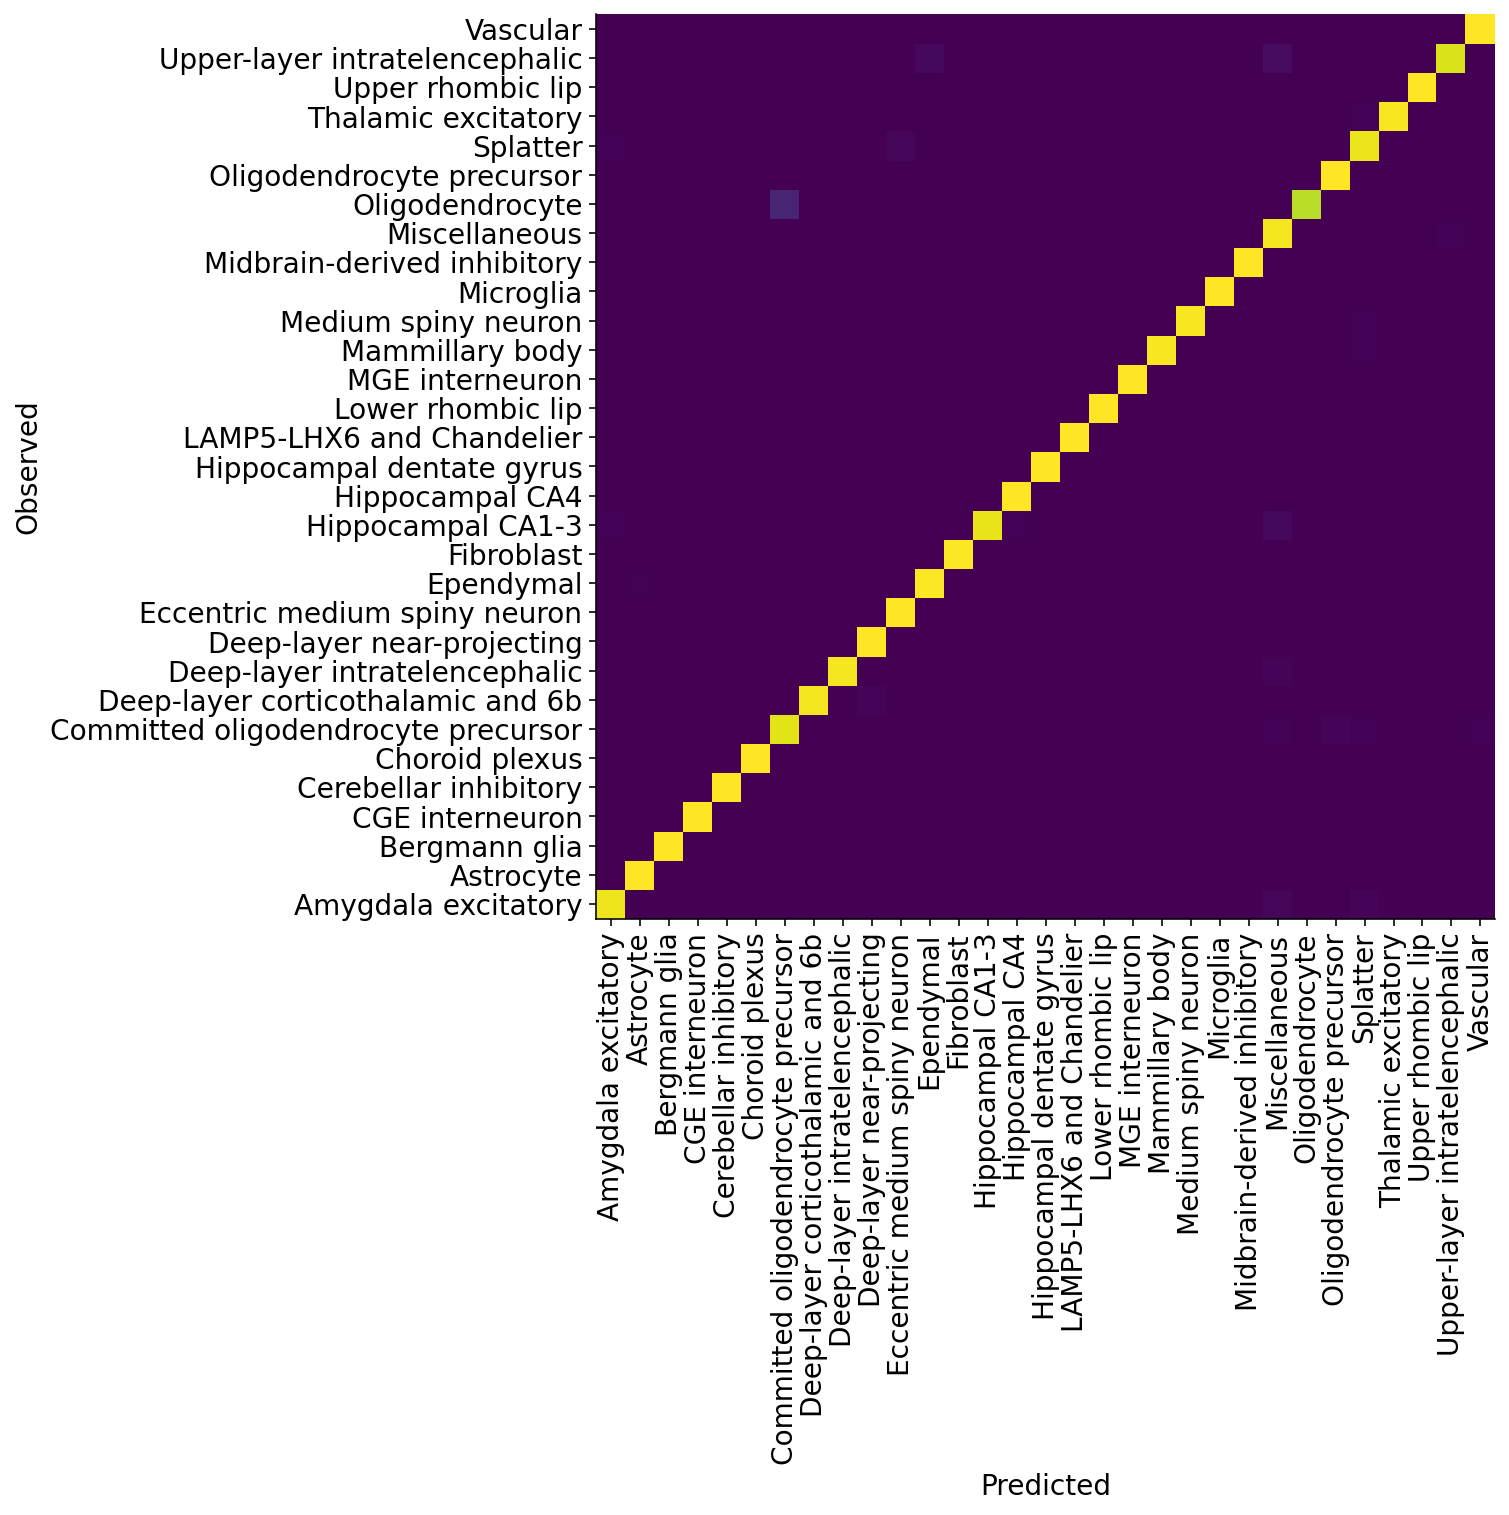

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:32<00:00, 90.63s/it, loss=2.42e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:32<00:00, 90.41s/it, loss=2.42e+03, v_num=1]


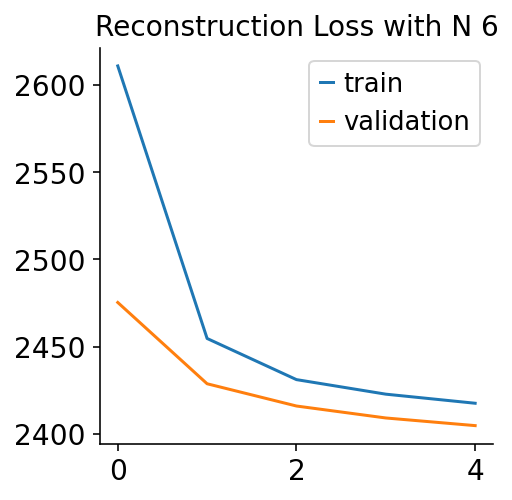

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [53:18<00:00, 1068.07s/it, loss=2.54e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [53:19<00:00, 1066.37s/it, loss=2.54e+03, v_num=1]


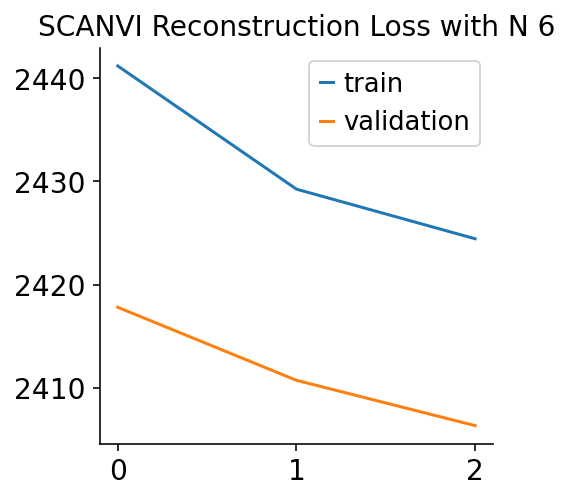

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

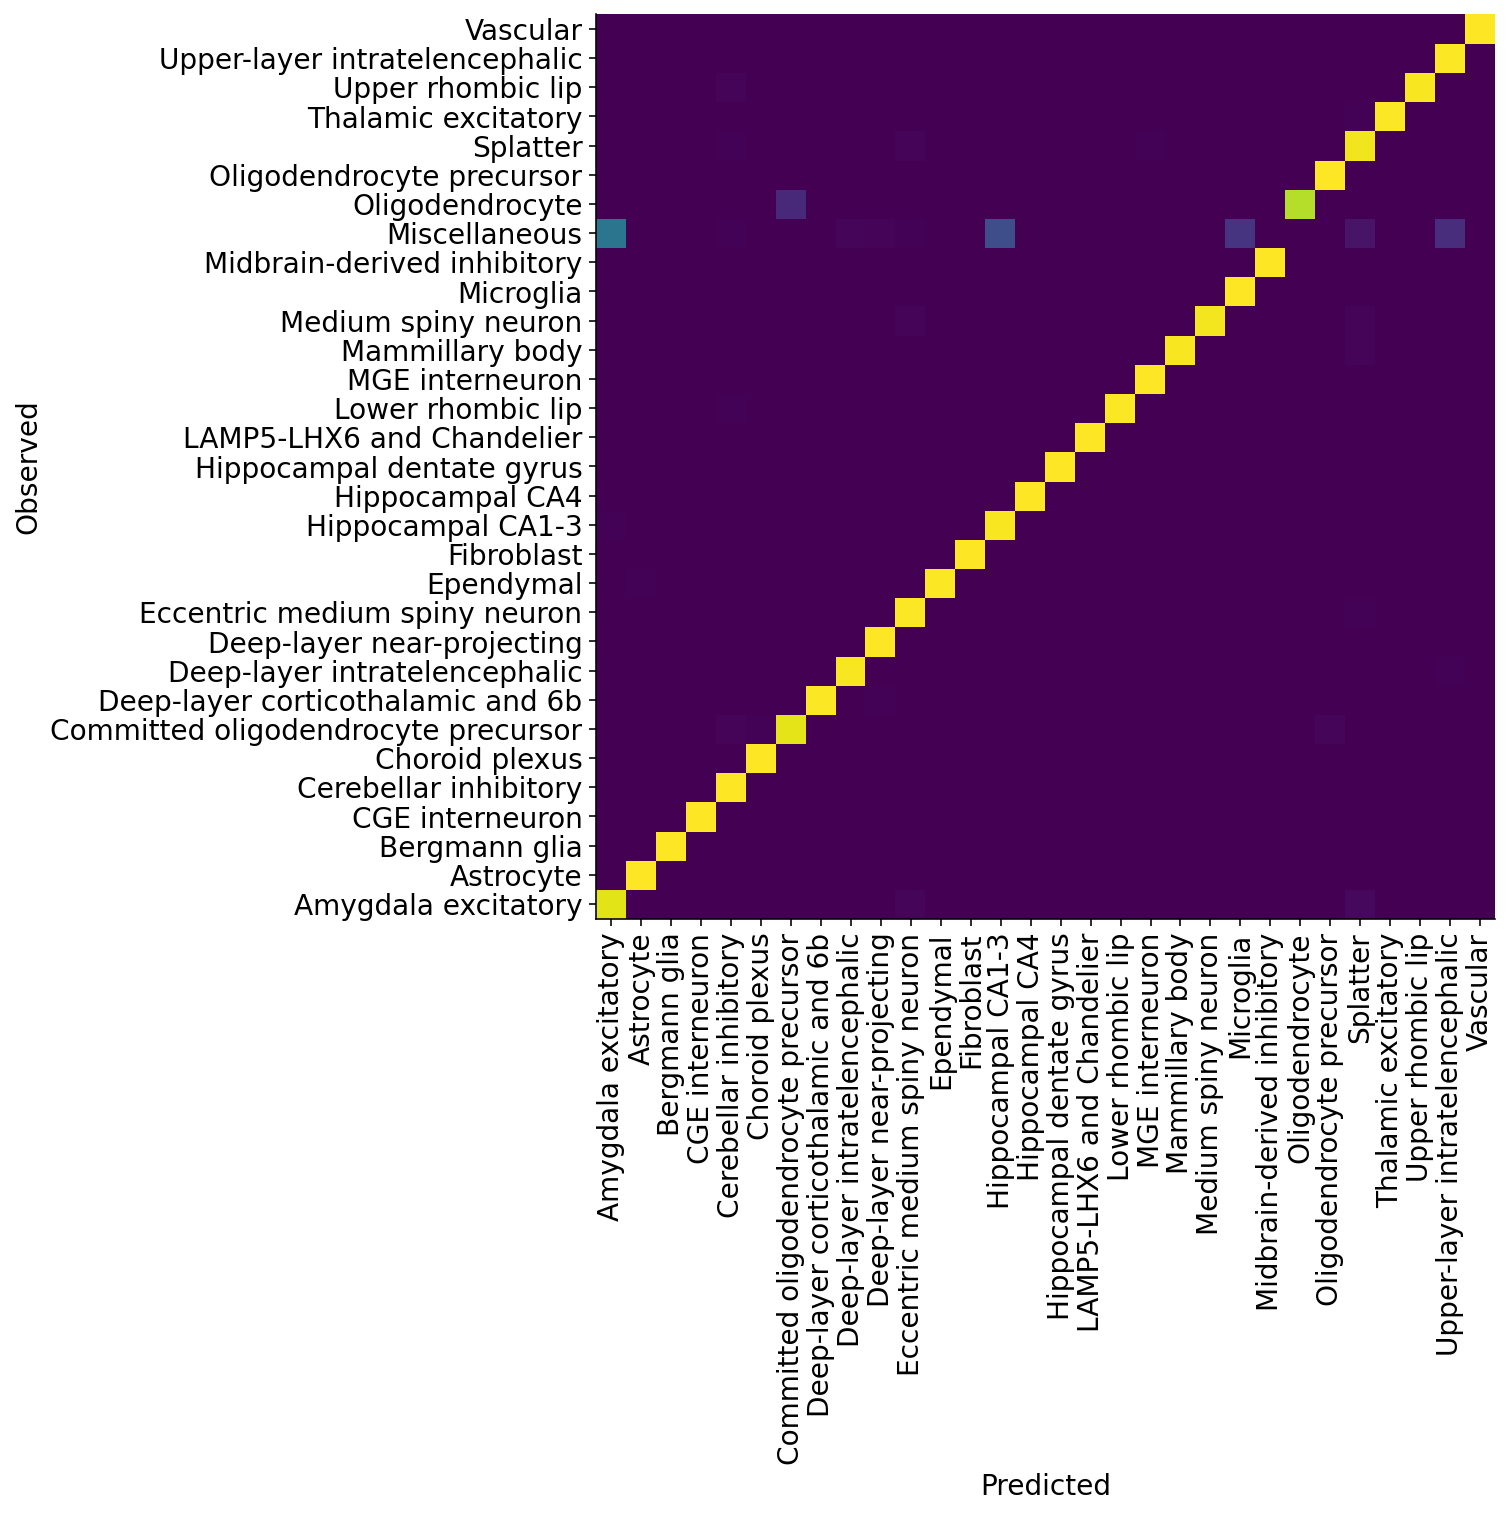

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [07:51<00:00, 94.32s/it, loss=2.43e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [07:51<00:00, 94.39s/it, loss=2.43e+03, v_num=1]


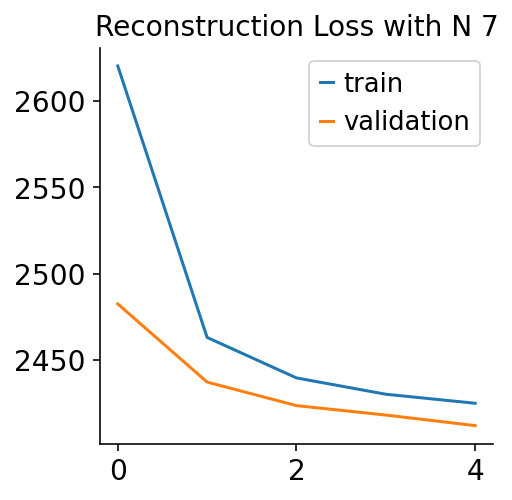

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [58:04<00:00, 1163.00s/it, loss=2.52e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [58:05<00:00, 1161.74s/it, loss=2.52e+03, v_num=1]


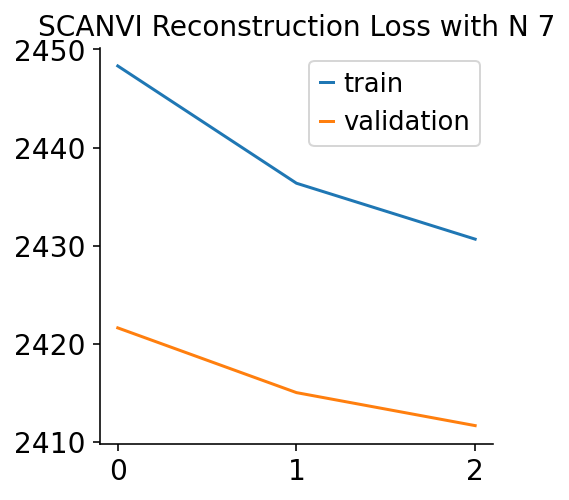

/tmp/ipykernel_83869/703048108.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_83869/703048108.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_83869/703048108.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel'][

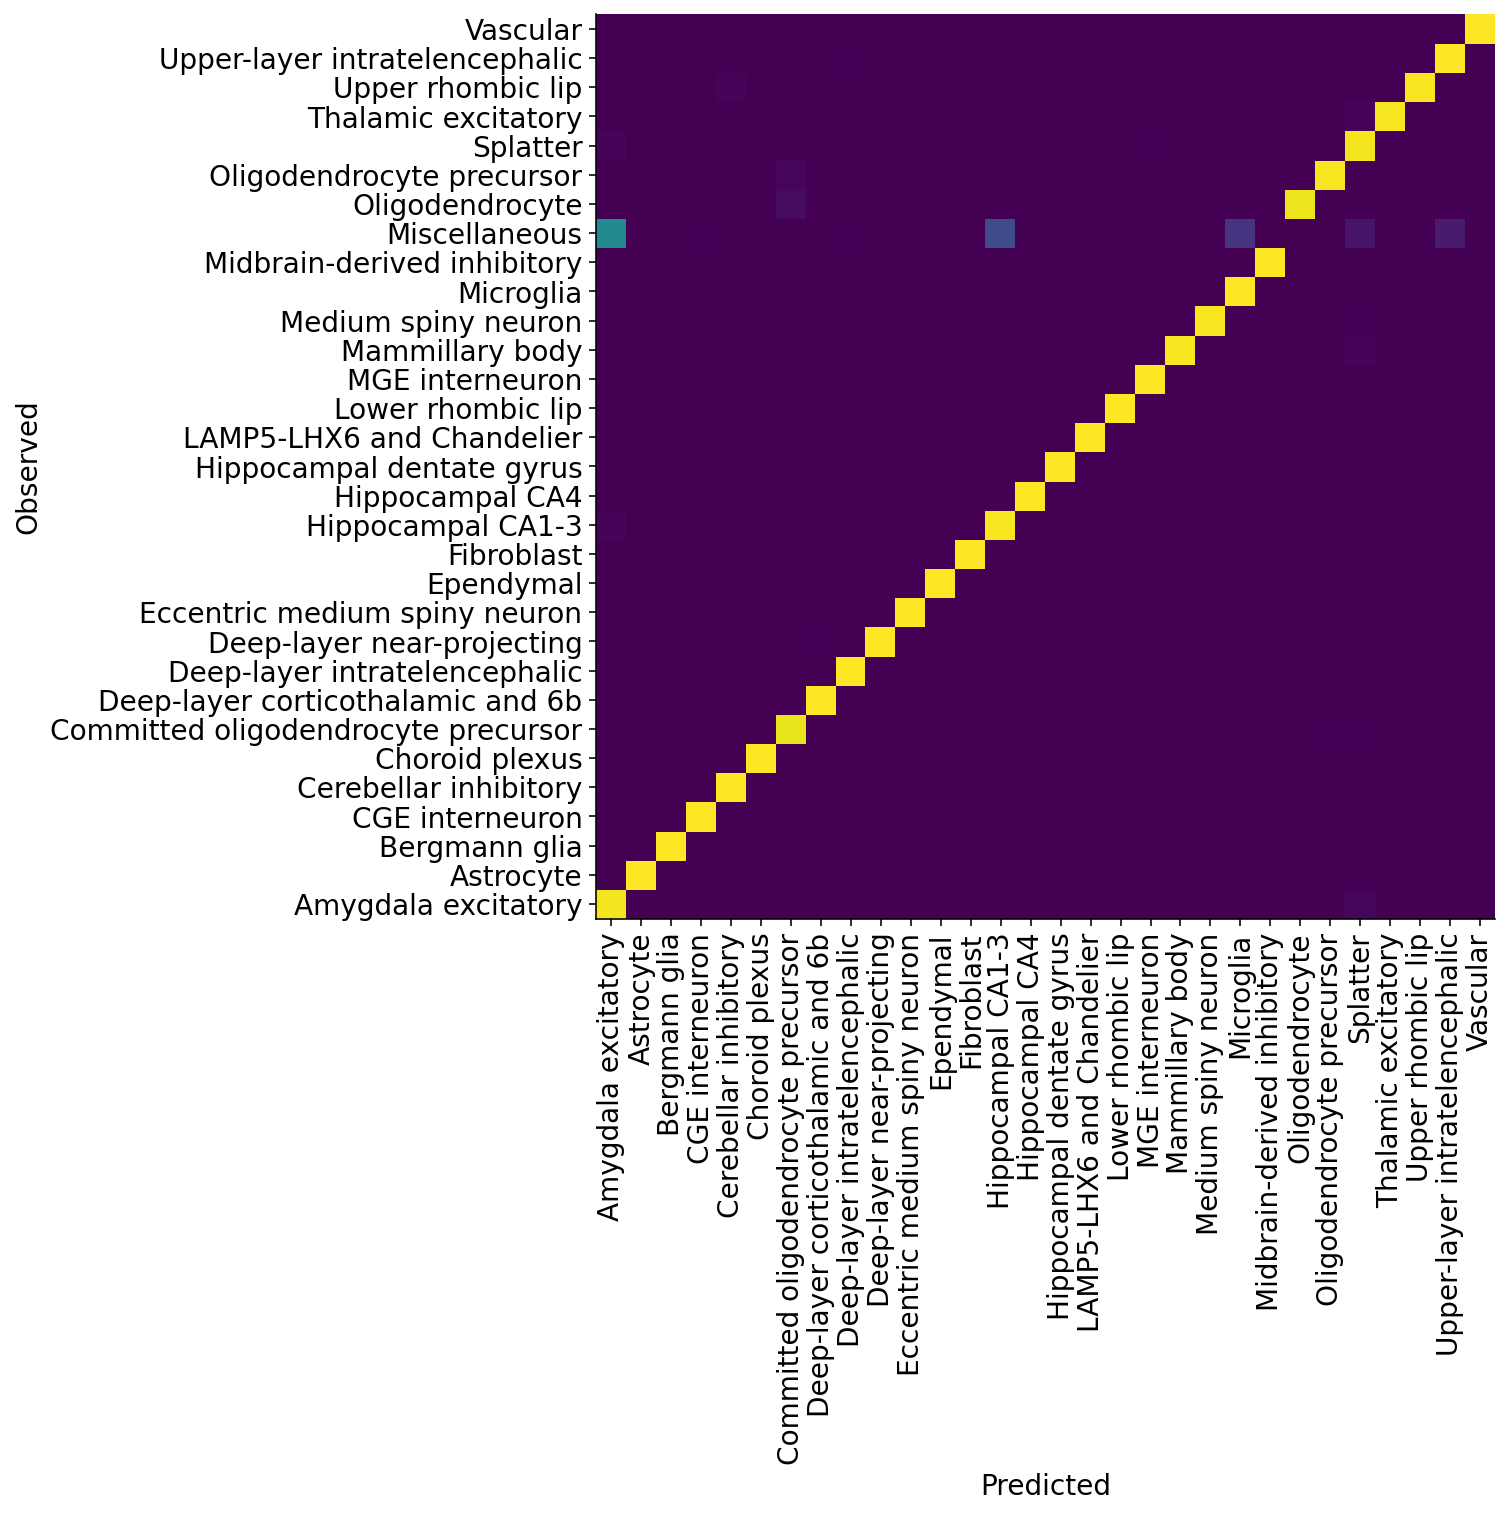

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [08:12<00:00, 98.55s/it, loss=2.43e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [08:12<00:00, 98.46s/it, loss=2.43e+03, v_num=1]


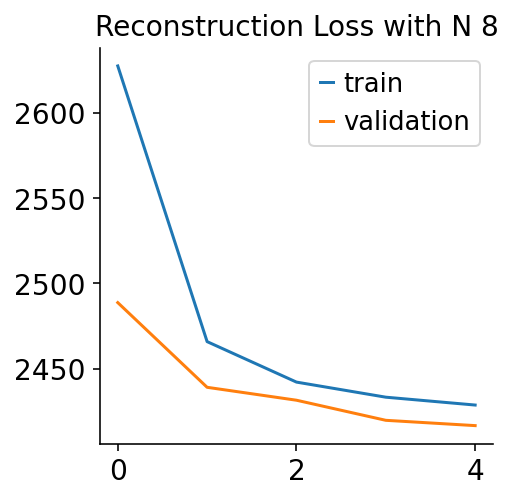

/tmp/ipykernel_83869/703048108.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 2/3:  33%|███▎      | 1/3 [20:50<41:40, 1250.29s/it, loss=2.59e+03, v_num=1]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 2>                                                                                │
│                                                                                                  │
│   21 │   │   unlabeled_category="Unknown",                                                       │
│   22 │   │   labels_key="celltype_scanvi",                                                       │
│   23 │   )                                                                                       │
│ ❱ 24 │   lvae_all.train(max_epochs=3,use_gpu=4,n_samples_per_label=1000,early_stopping=True,e    │
│   25 │   lvae_all.save(f'model/C50_scanvi_layer_n_{i}')                                          │
│   26 │   plt.plot(lvae_all.history['reconstruction_loss_train']['reconstruction_loss_train'],    │
│   27 │   plt.plot(lvae_all.history['reconstruction_loss_validation']['reconstruction_loss_val    │
│                                                                                                  │
│ /home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scvi/model/_scanvi.py:423 in train │
│                                                                                                  │
│   420 │   │   │   check_val_every_n_epoch=check_val_every_n_epoch,                               │
│   421 │   │   │   **trainer_kwargs,                                                              │
│   422 │   │   )                                                                                  │
│ ❱ 423 │   │   return runner()                                                                    │
│   424 │                                                                                          │
│   425 │   @classmethod                                                                           │
│   426 │   @setup_anndata_dsp.dedent                                                              │
│                                                                                                  │
│ /home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scvi/train/_trainrunner.py:83 in   │
│ __call__                                                                                         │
│                                                                                                  │
│    80 │   │   if hasattr(self.data_splitter, "n_val"):                                           │
│    81 │   │   │   self.training_plan.n_obs_validation = self.data_splitter.n_val                 │
│    82 │   │                                                                                      │
│ ❱  83 │   │   self.trainer.fit(self.training_plan, self.data_splitter)                           │
│    84 │   │   self._update_history()                                                             │
│    85 │   │                                                                                      │
│    86 │   │   # data splitter only gets these attrs after fit                                    │
│                                                                                                  │
│ /home/huang_yin/anaconda3/envs/sc/lib/python3.9/site-packages/scvi/train/_trainer.py:194 in fit  │
│                                                                                                  │
│   191 │   │   │   │   │   category=UserWarning,                                                  │
│   192 │   │   │   │   │   message="`LightningModule.configure_optimizers` returned `None`",      │
│   193 │   │   │   │   )                                                                          │
│ ❱ 194 │   │   │   super().fit(*args, **kwargs)                                                   │
│   195                                                                                            │
│                                                            

In [ ]:
results2=[]
for i in range(1,11):

    scvi.model.SCVI.setup_anndata(adata, layer="counts")
    vae = scvi.model.SCVI(adata, n_layers=i,n_latent=50)
    vae.train(max_epochs=5,use_gpu=4,train_size=0.8, batch_size=1024,early_stopping=True)
    vae.save(f'model/C50_layer_n_{i}')
    plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    np.random.seed(0)
    unlabel_idx=np.sort(np.random.choice(range(adata.shape[0]),int(adata.shape[0]*0.2),replace=False))
    adata.obs["celltype_scanvi"]=list(adata.obs.Supercluster)
    adata.obs.celltype_scanvi[unlabel_idx]='Unknown'
    lvae_all = scvi.model.SCANVI.from_scvi_model(
        vae,
        adata=adata,
        unlabeled_category="Unknown",
        labels_key="celltype_scanvi",
    )
    lvae_all.train(max_epochs=3,use_gpu=4,n_samples_per_label=1000,early_stopping=True,enable_checkpointing=True,check_val_every_n_epoch=1)
    lvae_all.save(f'model/C50_scanvi_layer_n_{i}')
    plt.plot(lvae_all.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(lvae_all.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'SCANVI Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    tmp1=adata.obs[['cell','Supercluster']]
    tmp1['predict']=lvae_all.predict()
    tmp1['unlabel']=False
    tmp1['unlabel'][unlabel_idx]=True
    results2.append([float(vae.get_elbo().cpu().numpy()),
                    float(lvae_all.get_elbo().cpu().numpy()),
                    sum((tmp1.Supercluster==tmp1.predict)[tmp1.unlabel])/sum(tmp1.unlabel),
                    sum((tmp1.Supercluster==tmp1.predict)[~tmp1.unlabel])/sum(~tmp1.unlabel)])
    
    df = tmp1[tmp1.unlabel].groupby(["Supercluster", "predict"]).size().unstack(fill_value=0)
    conf_mat = df / df.sum(axis=1).values[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    _ = plt.pcolor(conf_mat)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.show()

In [ ]:
results2

[[-2577.881591796875,
  -2570.99755859375,
  0.9725603738556311,
  0.9727796789761428],
 [-2557.36669921875,
  -2579.874755859375,
  0.9689601286946663,
  0.9693300674933664],
 [-2551.3359375, -2512.412353515625, 0.9568326746734773, 0.957084651640439],
 [-2539.20947265625,
  -2478.51513671875,
  0.9594593992962752,
  0.9595614860412796],
 [-2538.896484375, -2465.80859375, 0.9701621891152686, 0.9702772451784093],
 [-2523.65966796875, -2458.554931640625, 0.9689912932240893, 0.96866856423742],
 [-2523.846923828125,
  -2461.85595703125,
  0.9815698909093068,
  0.9812612414742878]]

In [ ]:
pd.DataFrame(results2,columns=['scvi','scanvi','validation','training']).to_csv('results/C50_layer_ns.csv')

In [ ]:
pd.DataFrame(results2,columns=['scvi','scanvi','validation','training'])

scvi       scanvi  validation  training
0 -2577.881592 -2570.997559    0.972560  0.972780
1 -2557.366699 -2579.874756    0.968960  0.969330
2 -2551.335938 -2512.412354    0.956833  0.957085
3 -2539.209473 -2478.515137    0.959459  0.959561
4 -2538.896484 -2465.808594    0.970162  0.970277
5 -2523.659668 -2458.554932    0.968991  0.968669
6 -2523.846924 -2461.855957    0.981570  0.981261

# 4 Random seed

[rank: 0] Global seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 5/5: 100%|██████████| 5/5 [06:21<00:00, 74.79s/it, loss=2.4e+03, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 5/5: 100%|██████████| 5/5 [06:21<00:00, 76.34s/it, loss=2.4e+03, v_num=1]


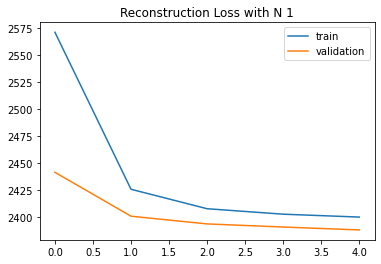

/tmp/ipykernel_128190/2656324141.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs.celltype_scanvi[unlabel_idx]='Unknown'


INFO     Training for 3 epochs.                                                                                    


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/huang_yin/anaconda3/envs/sc07/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/huang_yin/github/sc/projA/gsim/nbs/Revision/scvi_log/lightning_logs/version_1/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/3: 100%|██████████| 3/3 [38:09<00:00, 765.21s/it, loss=2.56e+03, v_num=1]

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 3/3: 100%|██████████| 3/3 [38:09<00:00, 763.24s/it, loss=2.56e+03, v_num=1]


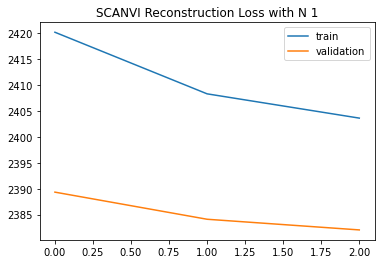

/tmp/ipykernel_128190/2656324141.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['predict']=lvae_all.predict()
/tmp/ipykernel_128190/2656324141.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unlabel']=False
/tmp/ipykernel_128190/2656324141.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp1['unla

[-2514.9833984375, -2514.935791015625, 0.9201119548618892, 0.9198679516327221]


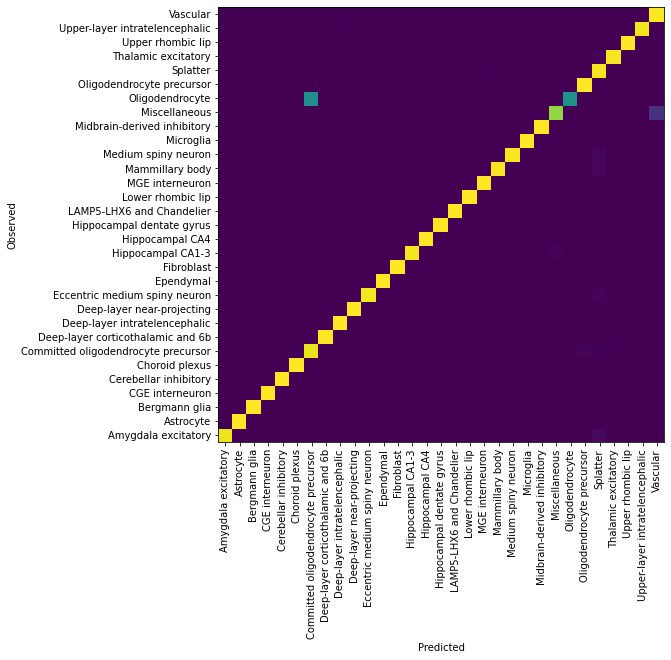

[rank: 0] Global seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
SLURM auto-requeueing enabled. Setting signal handlers.


Epoch 3/5:  40%|████      | 2/5 [02:37<03:56, 78.72s/it, loss=2.41e+03, v_num=1]

In [ ]:
results4=[]
for i in range(1,11):
    scvi.settings.seed = i
    scvi.model.SCVI.setup_anndata(adata, layer="counts")
    vae = scvi.model.SCVI(adata, n_layers=2,n_latent=32)
    vae.train(max_epochs=5,use_gpu=4,train_size=0.8, batch_size=1024,early_stopping=True)
    vae.save(f'model/random_seed_{i}')
    plt.plot(vae.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(vae.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    np.random.seed(0)
    unlabel_idx=np.sort(np.random.choice(range(adata.shape[0]),int(adata.shape[0]*0.2),replace=False))
    adata.obs["celltype_scanvi"]=list(adata.obs.Supercluster)
    adata.obs.celltype_scanvi[unlabel_idx]='Unknown'
    lvae_all = scvi.model.SCANVI.from_scvi_model(
        vae,
        adata=adata,
        unlabeled_category="Unknown",
        labels_key="celltype_scanvi",
    )
    lvae_all.train(max_epochs=3,use_gpu=4,n_samples_per_label=1000,early_stopping=True,enable_checkpointing=True,check_val_every_n_epoch=1)
    lvae_all.save(f'model/scanvi_random_seed_{i}')
    plt.plot(lvae_all.history['reconstruction_loss_train']['reconstruction_loss_train'], label='train');
    plt.plot(lvae_all.history['reconstruction_loss_validation']['reconstruction_loss_validation'], label='validation');
    plt.title(f'SCANVI Reconstruction Loss with N {i}')
    plt.legend()
    plt.show()

    tmp1=adata.obs[['cell','Supercluster']]
    tmp1['predict']=lvae_all.predict()
    tmp1['unlabel']=False
    tmp1['unlabel'][unlabel_idx]=True
    print([float(vae.get_elbo().cpu().numpy()),
                    float(lvae_all.get_elbo().cpu().numpy()),
                    sum((tmp1.Supercluster==tmp1.predict)[tmp1.unlabel])/sum(tmp1.unlabel),
                    sum((tmp1.Supercluster==tmp1.predict)[~tmp1.unlabel])/sum(~tmp1.unlabel)])
    
    results4.append([float(vae.get_elbo().cpu().numpy()),
                    float(lvae_all.get_elbo().cpu().numpy()),
                    sum((tmp1.Supercluster==tmp1.predict)[tmp1.unlabel])/sum(tmp1.unlabel),
                    sum((tmp1.Supercluster==tmp1.predict)[~tmp1.unlabel])/sum(~tmp1.unlabel)])
    
    df = tmp1[tmp1.unlabel].groupby(["Supercluster", "predict"]).size().unstack(fill_value=0)
    conf_mat = df / df.sum(axis=1).values[:, np.newaxis]
    plt.figure(figsize=(8, 8))
    _ = plt.pcolor(conf_mat)
    _ = plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns, rotation=90)
    _ = plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
    plt.xlabel("Predicted")
    plt.ylabel("Observed")
    plt.show()

In [ ]:
results4

[[-2514.983642578125,
  -2514.935791015625,
  0.9201119548618892,
  0.9198679516327221],
 [-2514.73193359375,
  -2515.248291015625,
  0.9544671384877487,
  0.9551461465858566],
 [-2516.431396484375,
  -2519.1259765625,
  0.9568475149255835,
  0.9570657303470833],
 [-2515.49462890625, -2514.69091796875, 0.892786598658738, 0.892789354806157],
 [-2516.69384765625, -2515.587890625, 0.9087309655216422, 0.9086609808798476],
 [-2516.7724609375, -2514.693115234375, 0.975569976982769, 0.9757117374347772],
 [-2515.0634765625, -2519.17431640625, 0.9567762817154738, 0.9565778577831071],
 [-2514.221435546875,
  -2517.34814453125,
  0.9454086486021225,
  0.9459837885326574],
 [-2518.018310546875, -2517.0400390625, 0.906672622554512, 0.9065113735523356],
 [-2515.67333984375,
  -2514.810302734375,
  0.9063045843022781,
  0.9060442773104754]]

In [ ]:
pd.DataFrame(results4,columns=['scvi','scanvi','validation','training']).to_csv('results/Random_seed.csv')

In [ ]:
pd.DataFrame(results4,columns=['scvi','scanvi','validation','training'])

scvi       scanvi  validation  training
0 -2514.983643 -2514.935791    0.920112  0.919868
1 -2514.731934 -2515.248291    0.954467  0.955146
2 -2516.431396 -2519.125977    0.956848  0.957066
3 -2515.494629 -2514.690918    0.892787  0.892789
4 -2516.693848 -2515.587891    0.908731  0.908661
5 -2516.772461 -2514.693115    0.975570  0.975712
6 -2515.063477 -2519.174316    0.956776  0.956578
7 -2514.221436 -2517.348145    0.945409  0.945984
8 -2518.018311 -2517.040039    0.906673  0.906511
9 -2515.673340 -2514.810303    0.906305  0.906044

# Plot

In [ ]:
import matplotlib as mpl
sc.set_figure_params(scanpy=True, fontsize=14,facecolor=None,frameon=False,transparent=True)
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.grid'] = False

In [ ]:
import seaborn as sns

In [ ]:
results=pd.DataFrame(results,columns=['scvi','scanvi','validation','training'])

In [ ]:
results['latent']=[i*10 for i in range(1,11)]

In [ ]:
results

scvi       scanvi  validation  training  latent
0 -2451.444092 -2452.386230    0.976530  0.976896      10
1 -2480.273438 -2479.841553    0.904533  0.904709      20
2 -2512.292480 -2509.780762    0.913685  0.913528      30
3 -2533.896973 -2535.517090    0.974982  0.975226      40
4 -2561.753418 -2562.859375    0.982727  0.982957      50
5 -2581.996338 -2589.395508    0.972431  0.972660      60
6 -2602.369629 -2582.683594    0.970204  0.970449      70
7 -2619.706299 -2599.223389    0.983717  0.983883      80
8 -2631.889160 -2586.561523    0.951842  0.952132      90
9 -2646.844727 -2652.302490    0.979617  0.979956     100

Text(0.5, 0, 'Latent dimension')

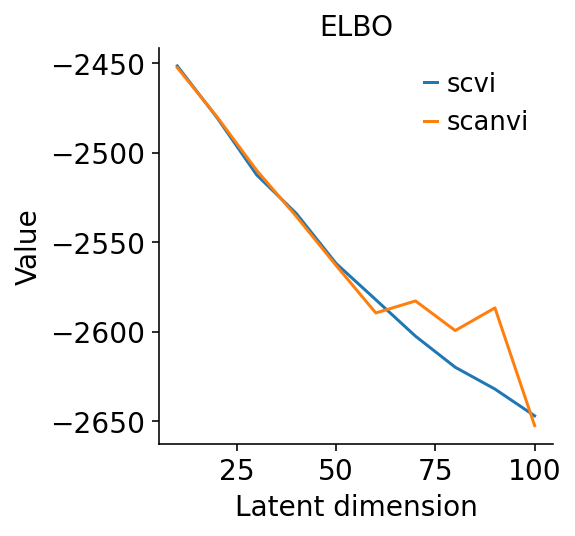

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='latent', y='scvi', data=results)
sns.lineplot(x='latent', y='scanvi',data=results)
plt.legend(labels=['scvi', 'scanvi'],frameon=False)
plt.title('ELBO')
plt.ylabel('Value')
plt.xlabel('Latent dimension')

Text(0.5, 0, 'Latent dimension')

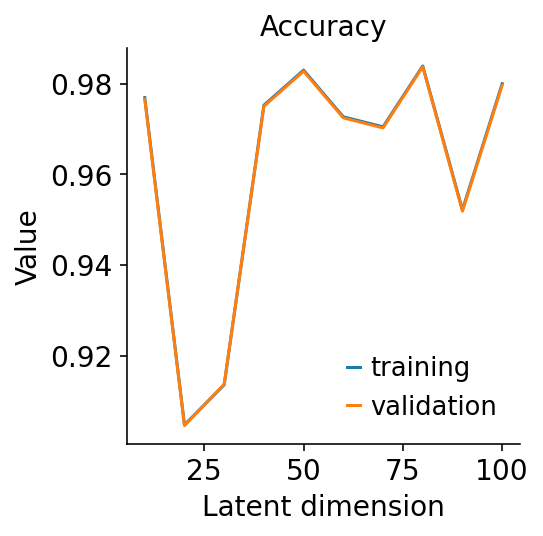

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='latent', y='training', data=results)
sns.lineplot(x='latent', y='validation',data=results)
plt.legend(labels=['training', 'validation'],frameon=False)
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Latent dimension')

In [ ]:
results1=pd.DataFrame(results1,columns=['scvi','scanvi','validation','training'])

In [ ]:
results1['layer']=[i for i in range(1,11)]

In [ ]:
results1

scvi       scanvi  validation  training  layer
0 -2474.871094 -2468.826904    0.972103  0.972591      1
1 -2450.970215 -2451.752197    0.982711  0.983025      2
2 -2448.159668 -2451.220703    0.954121  0.954308      3
3 -2448.189453 -2448.688721    0.965614  0.965901      4
4 -2452.828613 -2449.734619    0.970100  0.970347      5
5 -2455.523682 -2447.069580    0.975687  0.975807      6
6 -2463.993408 -2447.746338    0.948880  0.948644      7
7 -2470.672363 -2454.018066    0.980576  0.980533      8
8 -2475.444824 -2452.648682    0.963913  0.963810      9
9 -2486.048584 -2458.214844    0.846619  0.846527     10

Text(0.5, 0, 'Layers')

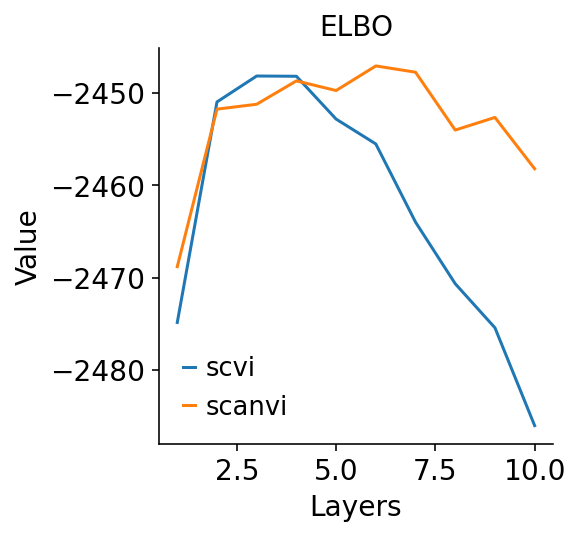

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='scvi', data=results1)
sns.lineplot(x='layer', y='scanvi',data=results1)
plt.legend(labels=['scvi', 'scanvi'],frameon=False)
plt.title('ELBO')
plt.ylabel('Value')
plt.xlabel('Layers')

Text(0.5, 0, 'Layers')

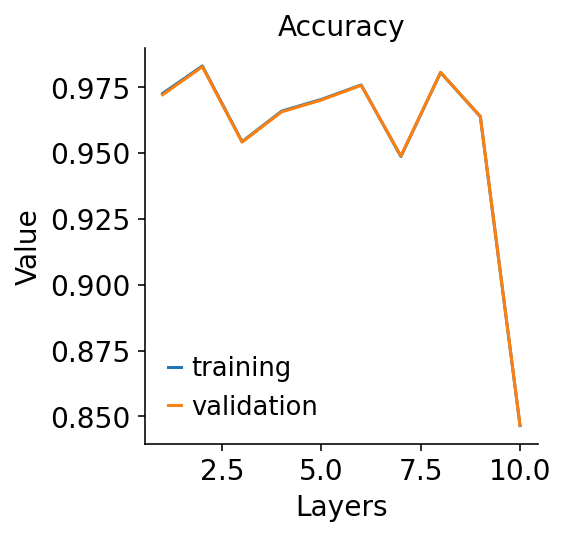

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='training', data=results1)
sns.lineplot(x='layer', y='validation',data=results1)
plt.legend(labels=['training', 'validation'],frameon=False)
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Layers')

In [ ]:
results2=pd.DataFrame(results2,columns=['scvi','scanvi','validation','training'])

In [ ]:
results2['layer']=[i for i in range(1,8)]

In [ ]:
results2

scvi       scanvi  validation  training  layer
0 -2577.881592 -2570.997559    0.972560  0.972780      1
1 -2557.366699 -2579.874756    0.968960  0.969330      2
2 -2551.335938 -2512.412354    0.956833  0.957085      3
3 -2539.209473 -2478.515137    0.959459  0.959561      4
4 -2538.896484 -2465.808594    0.970162  0.970277      5
5 -2523.659668 -2458.554932    0.968991  0.968669      6
6 -2523.846924 -2461.855957    0.981570  0.981261      7

Text(0.5, 0, 'Layers')

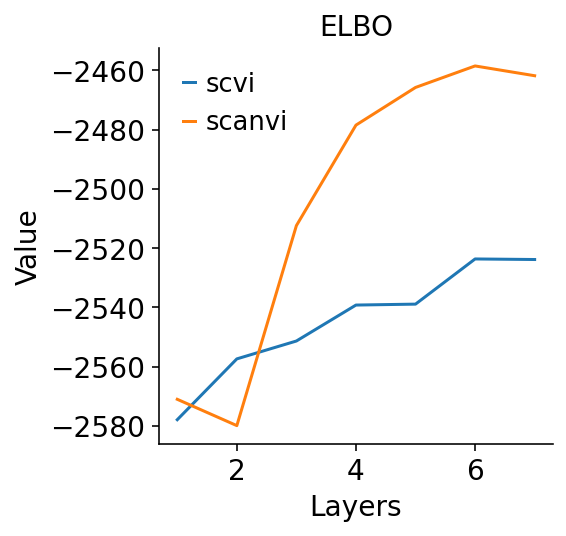

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='scvi', data=results2)
sns.lineplot(x='layer', y='scanvi',data=results2)
plt.legend(labels=['scvi', 'scanvi'],frameon=False)
plt.title('ELBO')
plt.ylabel('Value')
plt.xlabel('Layers')

Text(0.5, 0, 'Layers')

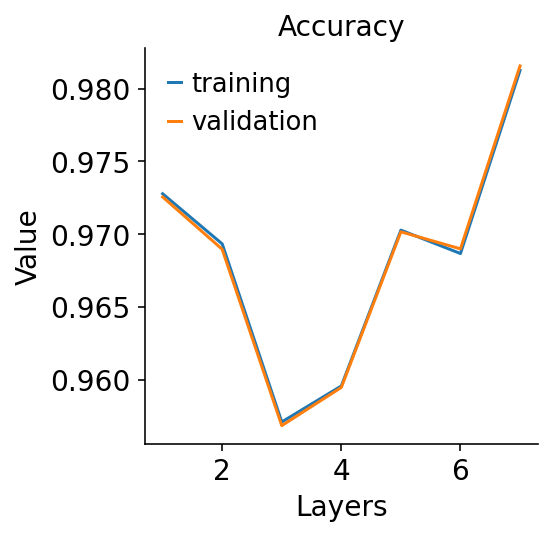

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='training', data=results2)
sns.lineplot(x='layer', y='validation',data=results2)
plt.legend(labels=['training', 'validation'],frameon=False)
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Layers')

In [ ]:
results4= pd.read_csv('results/Random_seed.csv')

In [ ]:
results4=pd.DataFrame(results4,columns=['scvi','scanvi','validation','training'])

In [ ]:
results4['Seed']=[i for i in range(1,11)]

In [ ]:
results4

Unnamed: 0         scvi       scanvi  validation  training  layer  Seed
0           0 -2514.983643 -2514.935791    0.920112  0.919868      1     1
1           1 -2514.731934 -2515.248291    0.954467  0.955146      2     2
2           2 -2516.431396 -2519.125977    0.956848  0.957066      3     3
3           3 -2515.494629 -2514.690918    0.892787  0.892789      4     4
4           4 -2516.693848 -2515.587891    0.908731  0.908661      5     5
5           5 -2516.772461 -2514.693115    0.975570  0.975712      6     6
6           6 -2515.063477 -2519.174316    0.956776  0.956578      7     7
7           7 -2514.221436 -2517.348145    0.945409  0.945984      8     8
8           8 -2518.018311 -2517.040039    0.906673  0.906511      9     9
9           9 -2515.673340 -2514.810303    0.906305  0.906044     10    10

In [ ]:
import seaborn as sns

In [1]:
1

1

Text(0.5, 0, 'Seeds')

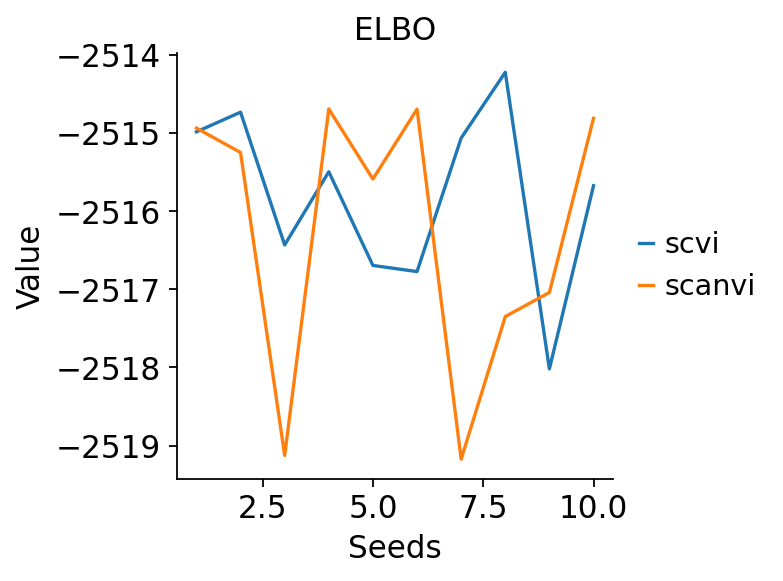

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='scvi', data=results4)
sns.lineplot(x='layer', y='scanvi',data=results4)
plt.legend(labels=['scvi', 'scanvi'],frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('ELBO')
plt.ylabel('Value')
plt.xlabel('Seeds')

Text(0.5, 0, 'Seeds')

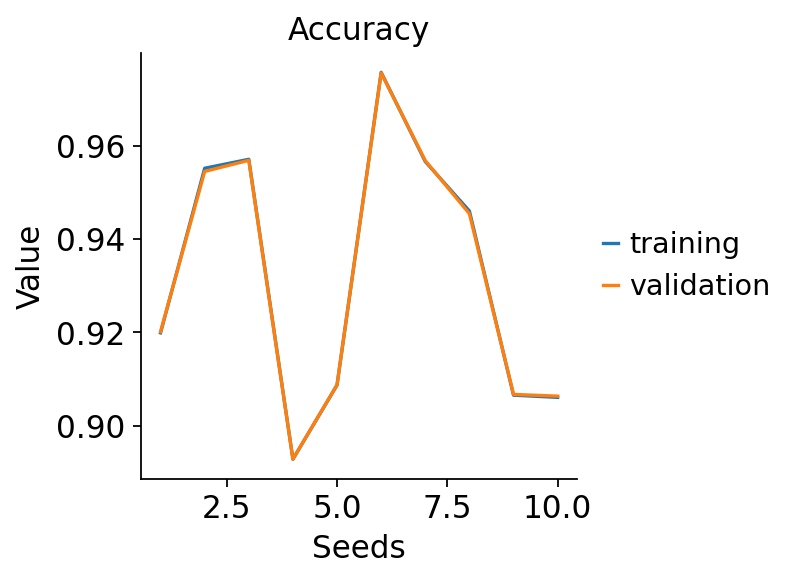

In [ ]:
figsize(3.5,3.5)
sns.lineplot(x='layer', y='training', data=results4)
sns.lineplot(x='layer', y='validation',data=results4)
plt.legend(labels=['training', 'validation'],frameon=False,loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Accuracy')
plt.ylabel('Value')
plt.xlabel('Seeds')